Population Time series data

### Importing Libraries

In [2]:
  import pandas as pd
  import numpy as np
  import seaborn as sns
  from tensorflow import keras
  import matplotlib as mpl
  import matplotlib.pyplot as plt
  from sklearn.preprocessing import StandardScaler
  from google.colab import files
  import io

In [3]:
uploaded = files.upload()

Saving POP.csv to POP.csv


In [4]:
df = pd.read_csv(io.BytesIO(uploaded['POP.csv']))

In [5]:
# Converting date to actual datetime
df['date'] = pd.to_datetime(df['date'])

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 816 entries, 0 to 815
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   realtime_start  816 non-null    object        
 1   value           816 non-null    float64       
 2   date            816 non-null    datetime64[ns]
 3   realtime_end    816 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 25.6+ KB
None


Plotting Date vs population value: If the graph has linear pattern, our solution should have some good results.

<Axes: xlabel='date', ylabel='value'>

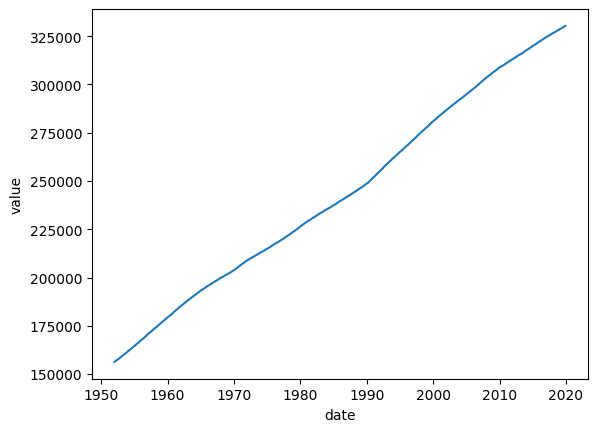

In [7]:
sns.lineplot(x="date",y="value",data=df)

Now we should convert the dataset into time series dataset

In [8]:
# Function to convert the dataset to a timeseries (specific for datasets with only the target column used)
def create_window(target, window=1, offset=0):
    feature_new, target_new = [], []
    # Convert our series to a numpy array
    target_np = target.to_numpy()
    for index in range(window, target.shape[0] - offset):
        feature_new.append(target_np[index - window: index])
        target_new.append(target_np[index+offset])
    return np.array(feature_new), np.array(target_new)

The create_window function is used to create the timeseries based on the target column we want. It assumes the data is already sorted by date and values are not null


In [9]:
df = df.sort_values(by=['date'])
window = 5
feature, target = create_window(df['value'], window=window)
print(feature[0])
print(target[0])
print(df.head(6))

[156309. 156527. 156731. 156943. 157140.]
157343.0
  realtime_start     value       date realtime_end
0     2019-12-06  156309.0 1952-01-01   2019-12-06
1     2019-12-06  156527.0 1952-02-01   2019-12-06
2     2019-12-06  156731.0 1952-03-01   2019-12-06
3     2019-12-06  156943.0 1952-04-01   2019-12-06
4     2019-12-06  157140.0 1952-05-01   2019-12-06
5     2019-12-06  157343.0 1952-06-01   2019-12-06


If we pass window = 5 to the create_window() function, the feature set for each prediction will consist of the previous 5 values of the target variable. For example, suppose we have the following time series data:

target = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
If we call the create_window() function with window=5, it will create feature sets consisting of the previous 5 values of the target variable, and a corresponding target value. The first feature set and target value will be:

feature_set = [10, 20, 30, 40, 50]
target_value = 60
The second feature set and target value will be:

feature_set = [20, 30, 40, 50, 60]
target_value = 70

**Now we will try to scale the features**

In [10]:
scaler_feature = StandardScaler()
feature_shape = feature.shape
feature_scaled = scaler_feature.fit_transform(feature)

In [11]:
feature_scaled[1]

array([-1.72931809, -1.72958014, -1.7296833 , -1.73008718, -1.73037365])

**Now we will scale the target value**

In [12]:
scaler_target = StandardScaler()
target_scaled = scaler_target.fit_transform(target.reshape(-1,1))
target_scaled[0]

array([-1.73471032])

Scaling the values of feature and target is very important to extract the best results of our model, so we do that with both target and feature.



**Splitting the dataset into Test and train**

In [13]:
# This function split the dataset in train and test, but in a direct way, so we can maintain the date
def train_test(feature, target, perc_train = 0.8):
    size_train = int(len(feature) * perc_train)

    x_train = feature[0:size_train]
    y_train = target[0:size_train]

    x_test = feature[size_train: len(feature)]
    y_test = target[size_train: len(feature)]

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = train_test(feature_scaled, target_scaled)


*We have not used train_test_split beacuse we want to maintain the order of the data. Since it is a time series data, it is important to keep the dates in the correct order.*

Text(0.5, 0, 'Date')

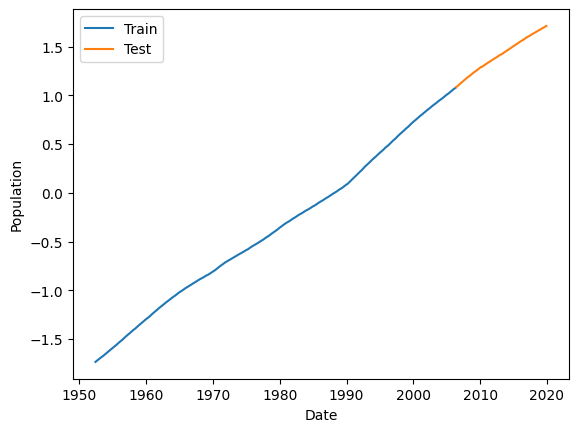

In [14]:
sns.lineplot(x=df['date'].iloc[window:len(y_train) + window], y=y_train[:,0], label='Train')
sns.lineplot(x=df['date'].iloc[len(y_train) + window:], y=y_test[:,0], label='Test')
plt.ylabel('Population')
plt.xlabel('Date')

# **Model Creation**

**Neural Network (LSTM)**

In [ ]:
# we need to reshape the feature values, because the LSTM model
# requires a 3D input with dimensions of (batch_size, time_steps, features), 
# where batch_size refers to the number of samples, time_steps refers 
# to the number of time steps or sequence length, and features refers to the 
# number of input features. 

In [15]:
x_train,x_test = x_train.reshape(-1,window,1), x_test.reshape(-1,window,1)

In [18]:
model = keras.Sequential()
model.add(keras.layers.LSTM(128,input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(keras.layers.Dense(units=1))

In [19]:
model.compile(loss="mean_squared_error",optimizer = "RMSProp")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [20]:
result = model.fit(x_train,y_train,validation_data=(x_test,y_test),
                   epochs=10)

Epoch 1/10
21/21 [==============================] - 3s 40ms/step - loss: 0.1430 - val_loss: 0.0512
Epoch 2/10
21/21 [==============================] - 0s 12ms/step - loss: 5.6106e-04 - val_loss: 0.0265
Epoch 3/10
21/21 [==============================] - 0s 18ms/step - loss: 0.0014 - val_loss: 0.0087
Epoch 4/10
21/21 [==============================] - 0s 22ms/step - loss: 0.0022 - val_loss: 0.0130
Epoch 5/10
21/21 [==============================] - 0s 21ms/step - loss: 9.9864e-04 - val_loss: 0.0126
Epoch 6/10
21/21 [==============================] - 0s 19ms/step - loss: 8.7317e-04 - val_loss: 0.0067
Epoch 7/10
21/21 [==============================] - 0s 20ms/step - loss: 0.0011 - val_loss: 0.0159
Epoch 8/10
21/21 [==============================] - 0s 19ms/step - loss: 0.0013 - val_loss: 0.0097
Epoch 9/10
21/21 [==============================] - 0s 21ms/step - loss: 0.0012 - val_loss: 0.0098
Epoch 10/10
21/21 [==============================] - 0s 19ms/step - loss: 0.0010 - val_loss: 0.00

Text(0, 0.5, 'Cost')

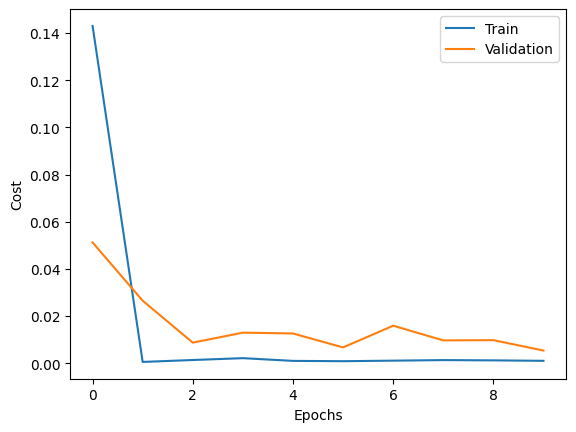

In [21]:
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(['Train','Validation'])
plt.xlabel('Epochs')
plt.ylabel('Cost')

In [16]:
# Function to print the charts comparing the original dataset with the predicted values
def results_chart(y_predicted, y_test, y_train, x_date, window):
    grid = plt.figure(figsize=(17,20))

    g1 = grid.add_subplot(2,1,1)
    g2 = grid.add_subplot(2,1,2)

    sns.lineplot(x=x_date[window:len(y_train) + window], y=y_train[:,0], label='Train', ax=g1)
    sns.lineplot(x=x_date[len(y_train) + window:], y=y_test[:,0], label='Test', ax=g1)
    sns.lineplot(x=x_date[len(y_train) + window:], y=y_predicted[:,0], label='Predicted', ax=g1)
    g1.set_title('Train x Test x Predict')

    sns.lineplot(x=x_date[len(y_train) + window:], y=y_test[:,0], label='Test', ax=g2)
    sns.lineplot(x=x_date[len(y_train) + window:], y=y_predicted[:,0], label='Predicted', ax=g2)
    g2.set_title('Test x Predict')


6/6 [==============================] - 1s 5ms/step


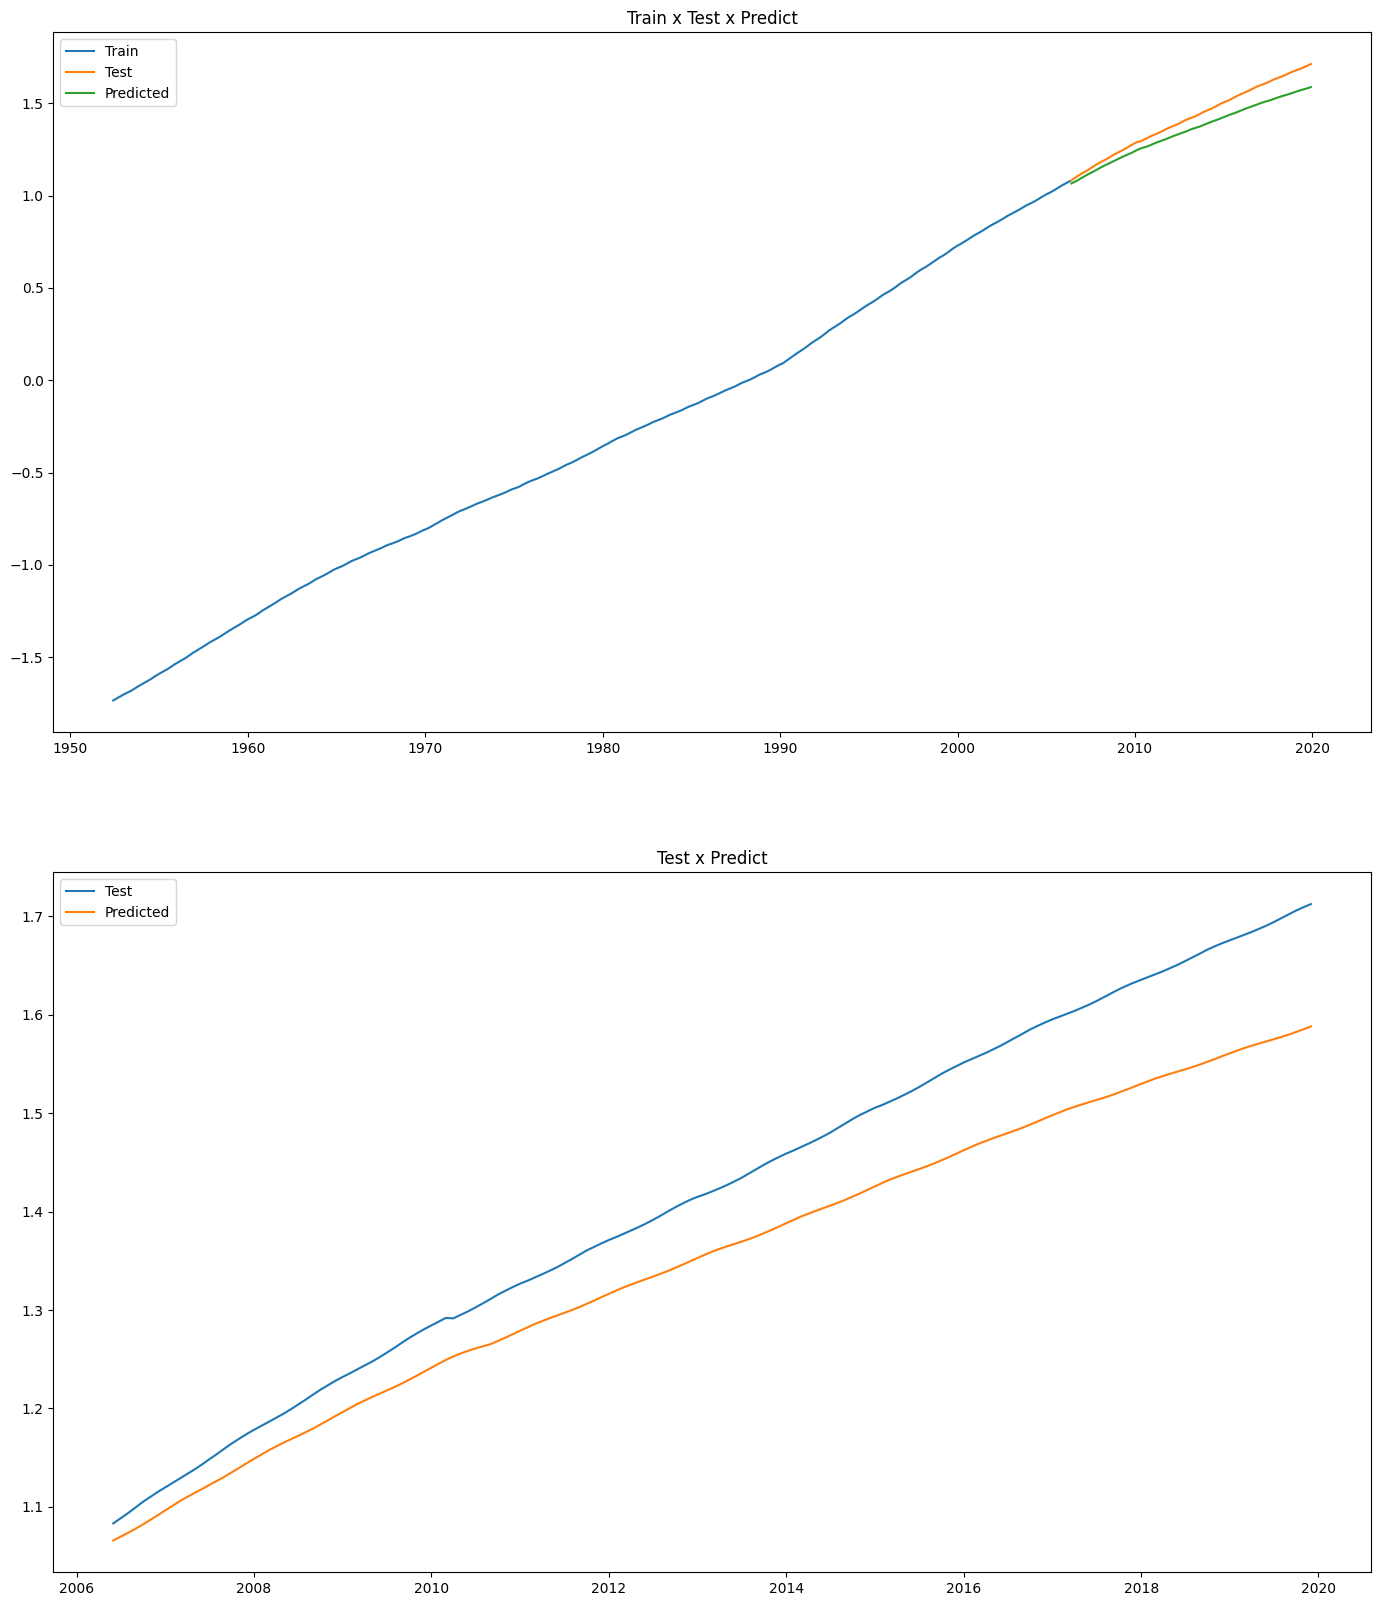

In [23]:
y_predicted = model.predict(x_test)

results_chart(y_predicted, y_test, y_train, df['date'].to_numpy(), window)

**Linear Regression**

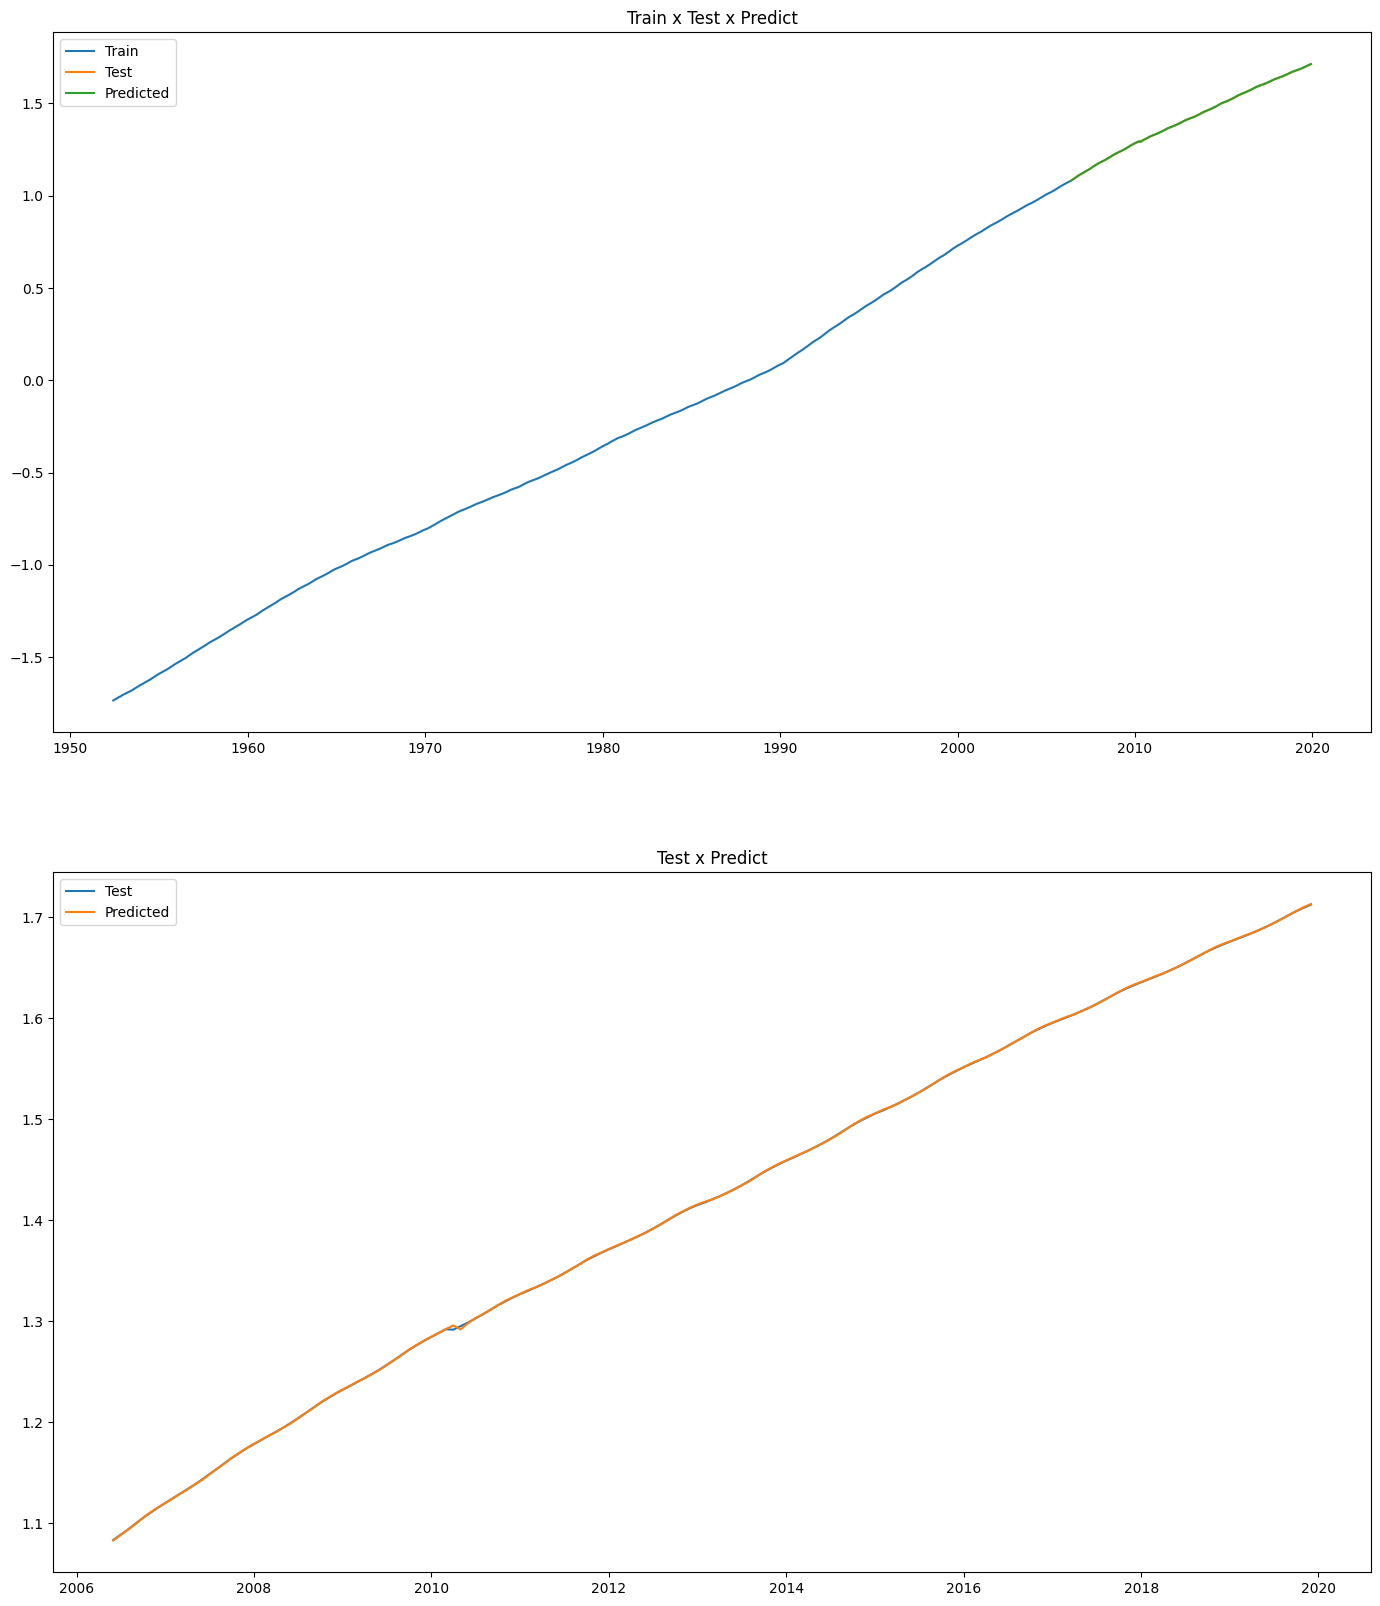

In [24]:
from sklearn.linear_model import LinearRegression

model_linear_reg = LinearRegression().fit(x_train.reshape(-1,window),y_train)
y_predicted = model_linear_reg.predict(x_test.reshape(-1,window))

results_chart(y_predicted,y_test,y_train,df['date'].to_numpy(),window)

**SV- Regresion**

In [26]:
from sklearn.svm import SVR

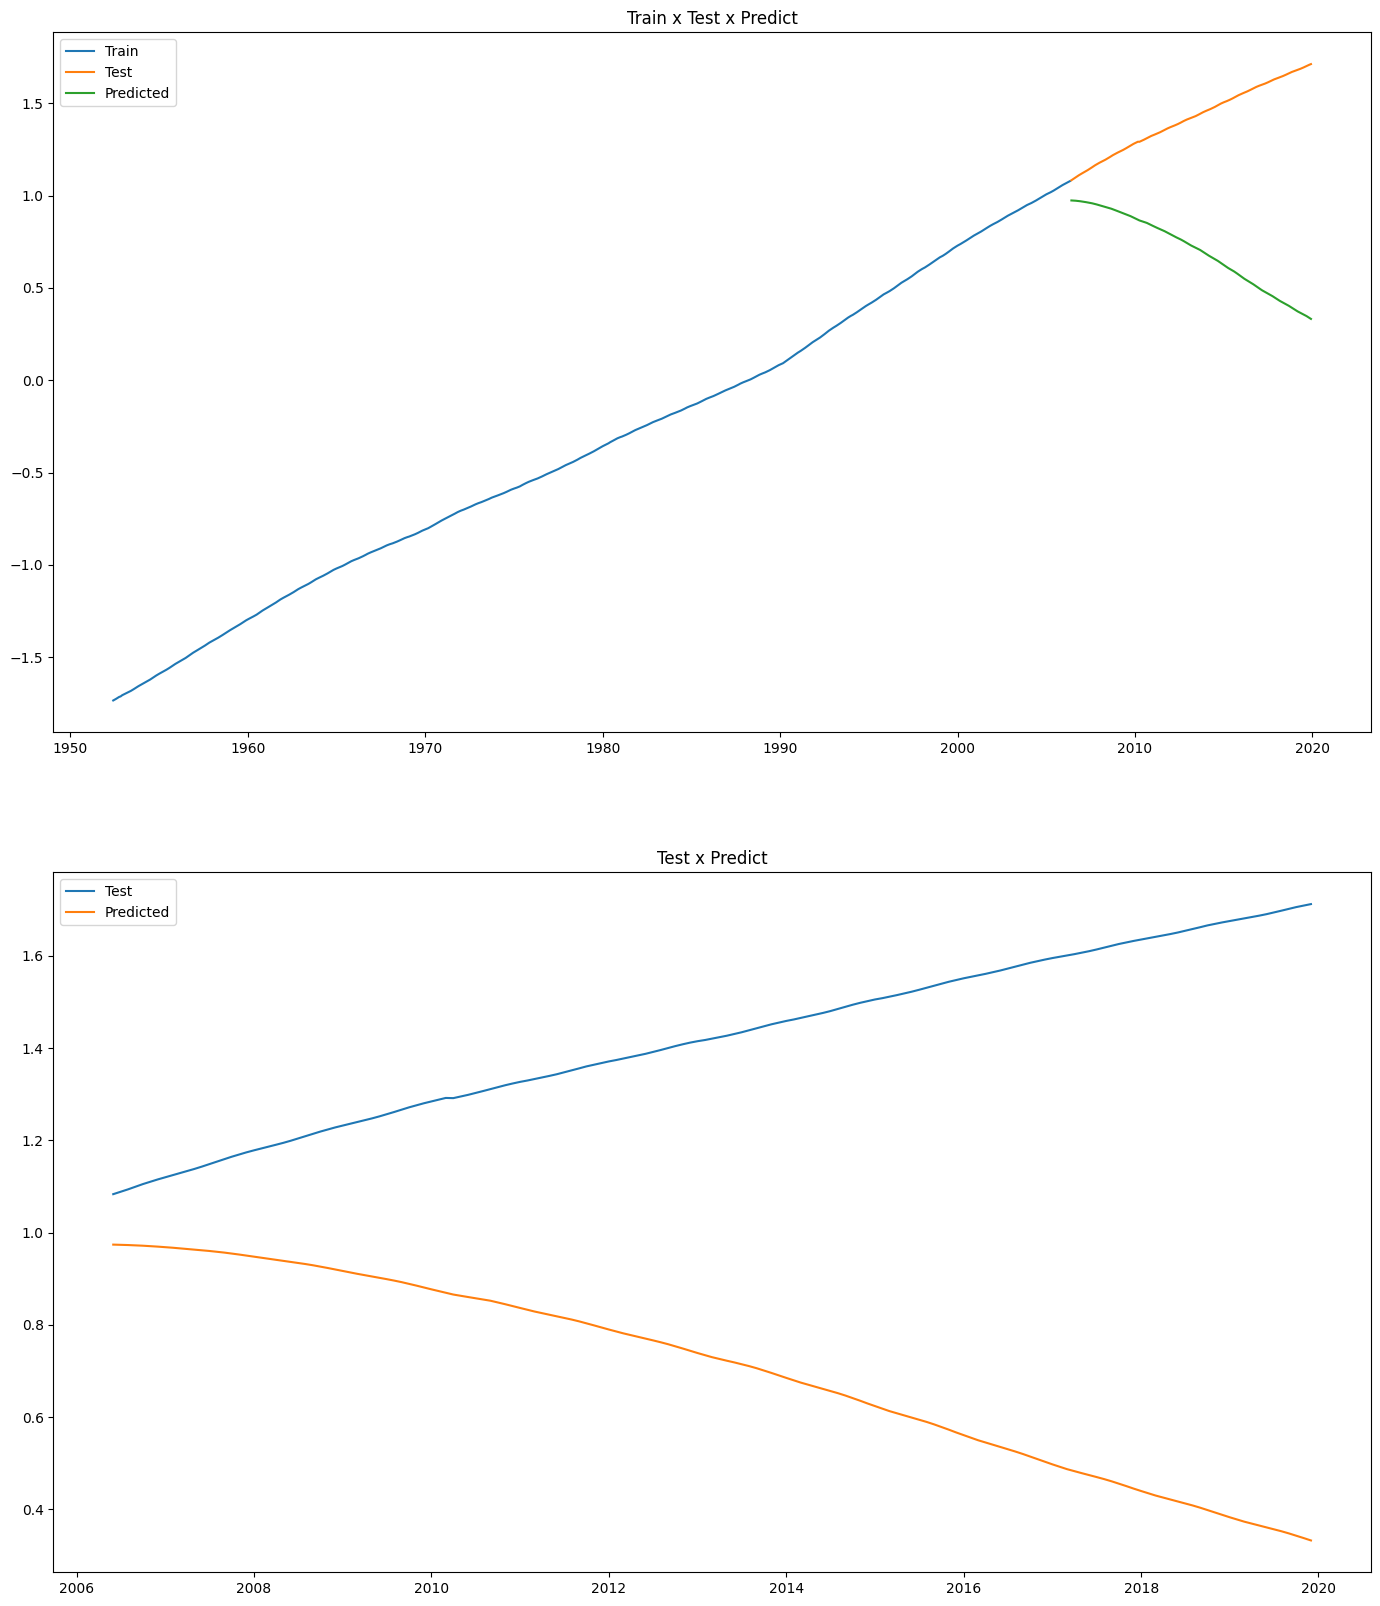

In [27]:
model_svr = SVR().fit(x_train.reshape(-1,window), y_train.reshape(-1))
y_predicted = model_svr.predict(x_test.reshape(-1,window)).reshape(-1,1)

results_chart(y_predicted, y_test, y_train, df['date'].to_numpy(), window)

SGD-**Regression**

In [28]:
from sklearn.linear_model import SGDRegressor


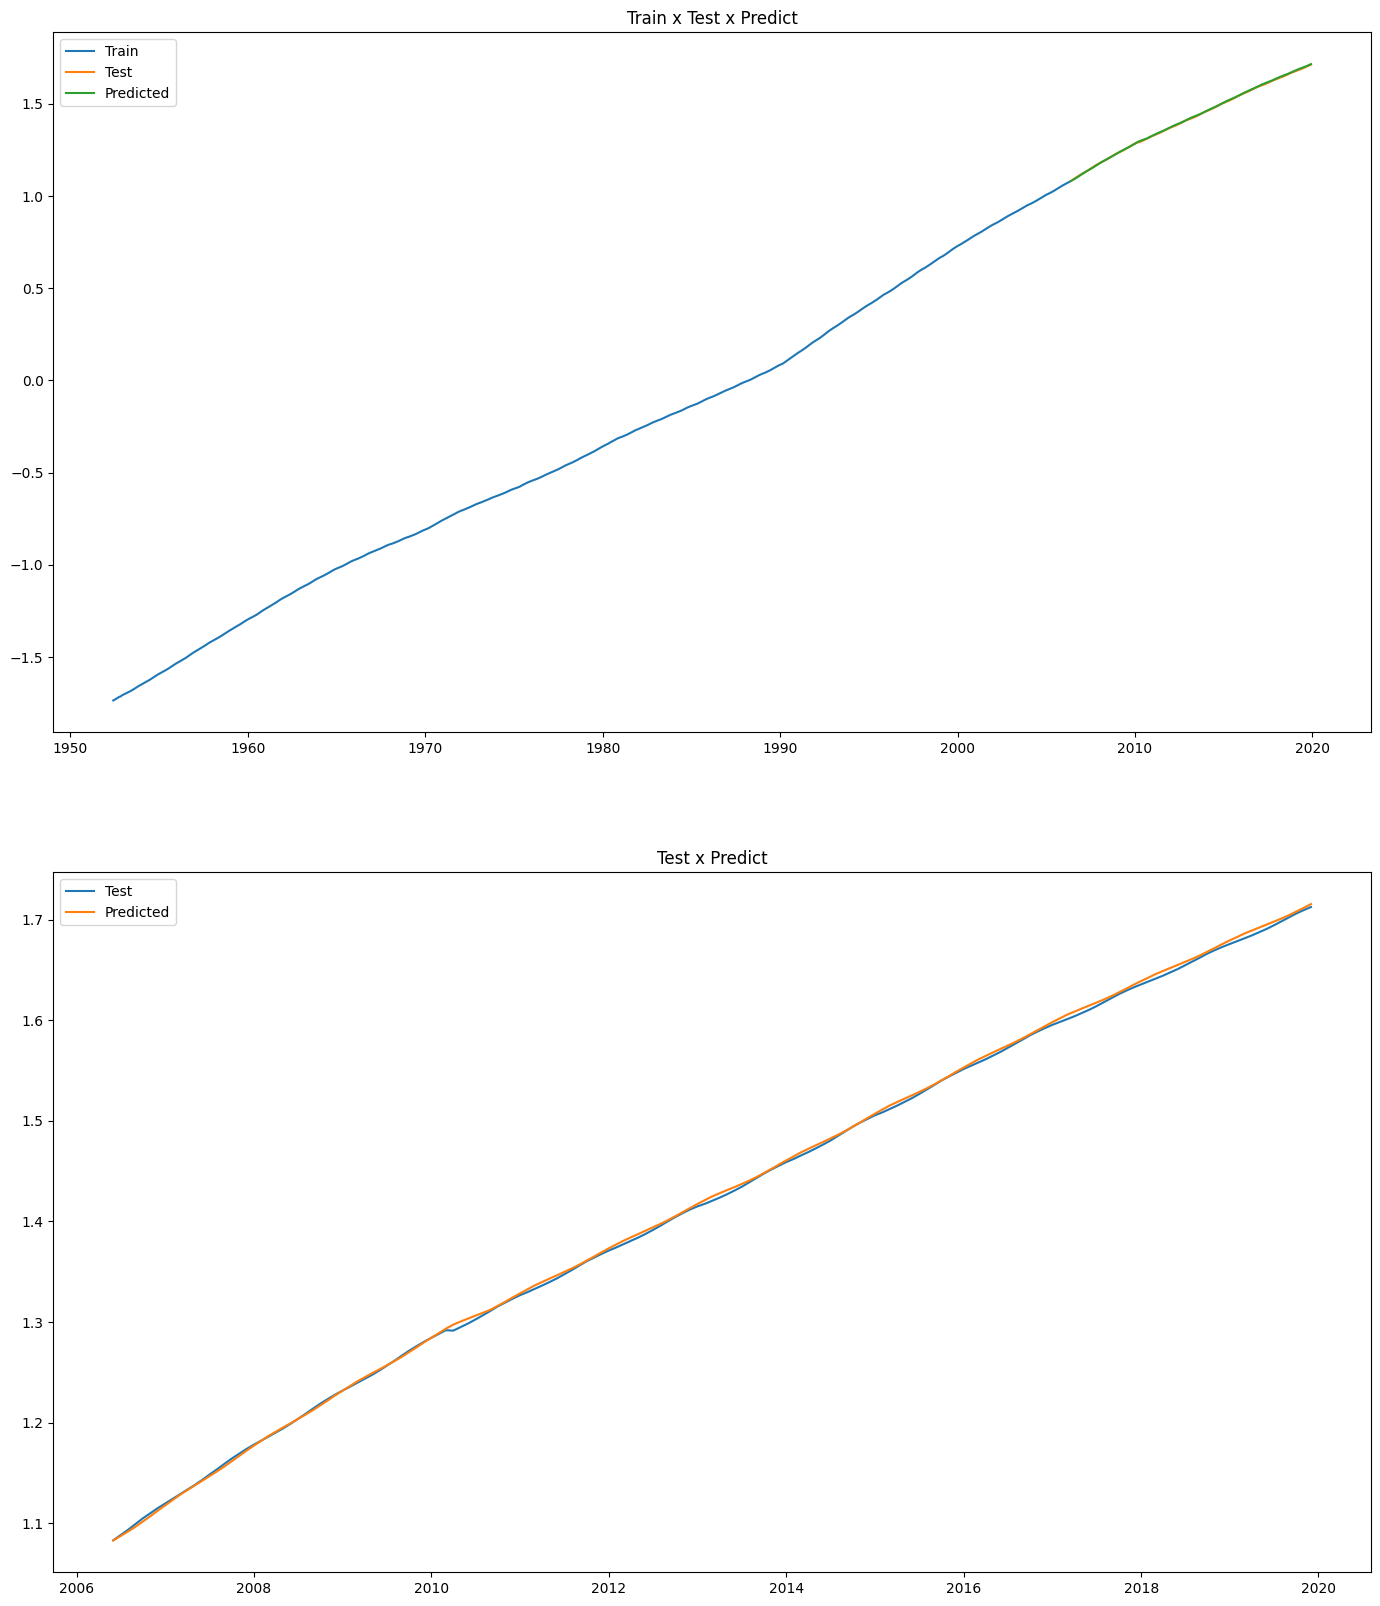

In [29]:
model_sdgr = SGDRegressor().fit(x_train.reshape(-1,window), y_train.reshape(-1))
y_predicted = model_sdgr.predict(x_test.reshape(-1,window)).reshape(-1,1)

results_chart(y_predicted, y_test, y_train, df['date'].to_numpy(), window)

**Decision tree regressor**

In [30]:
from sklearn.tree import DecisionTreeRegressor


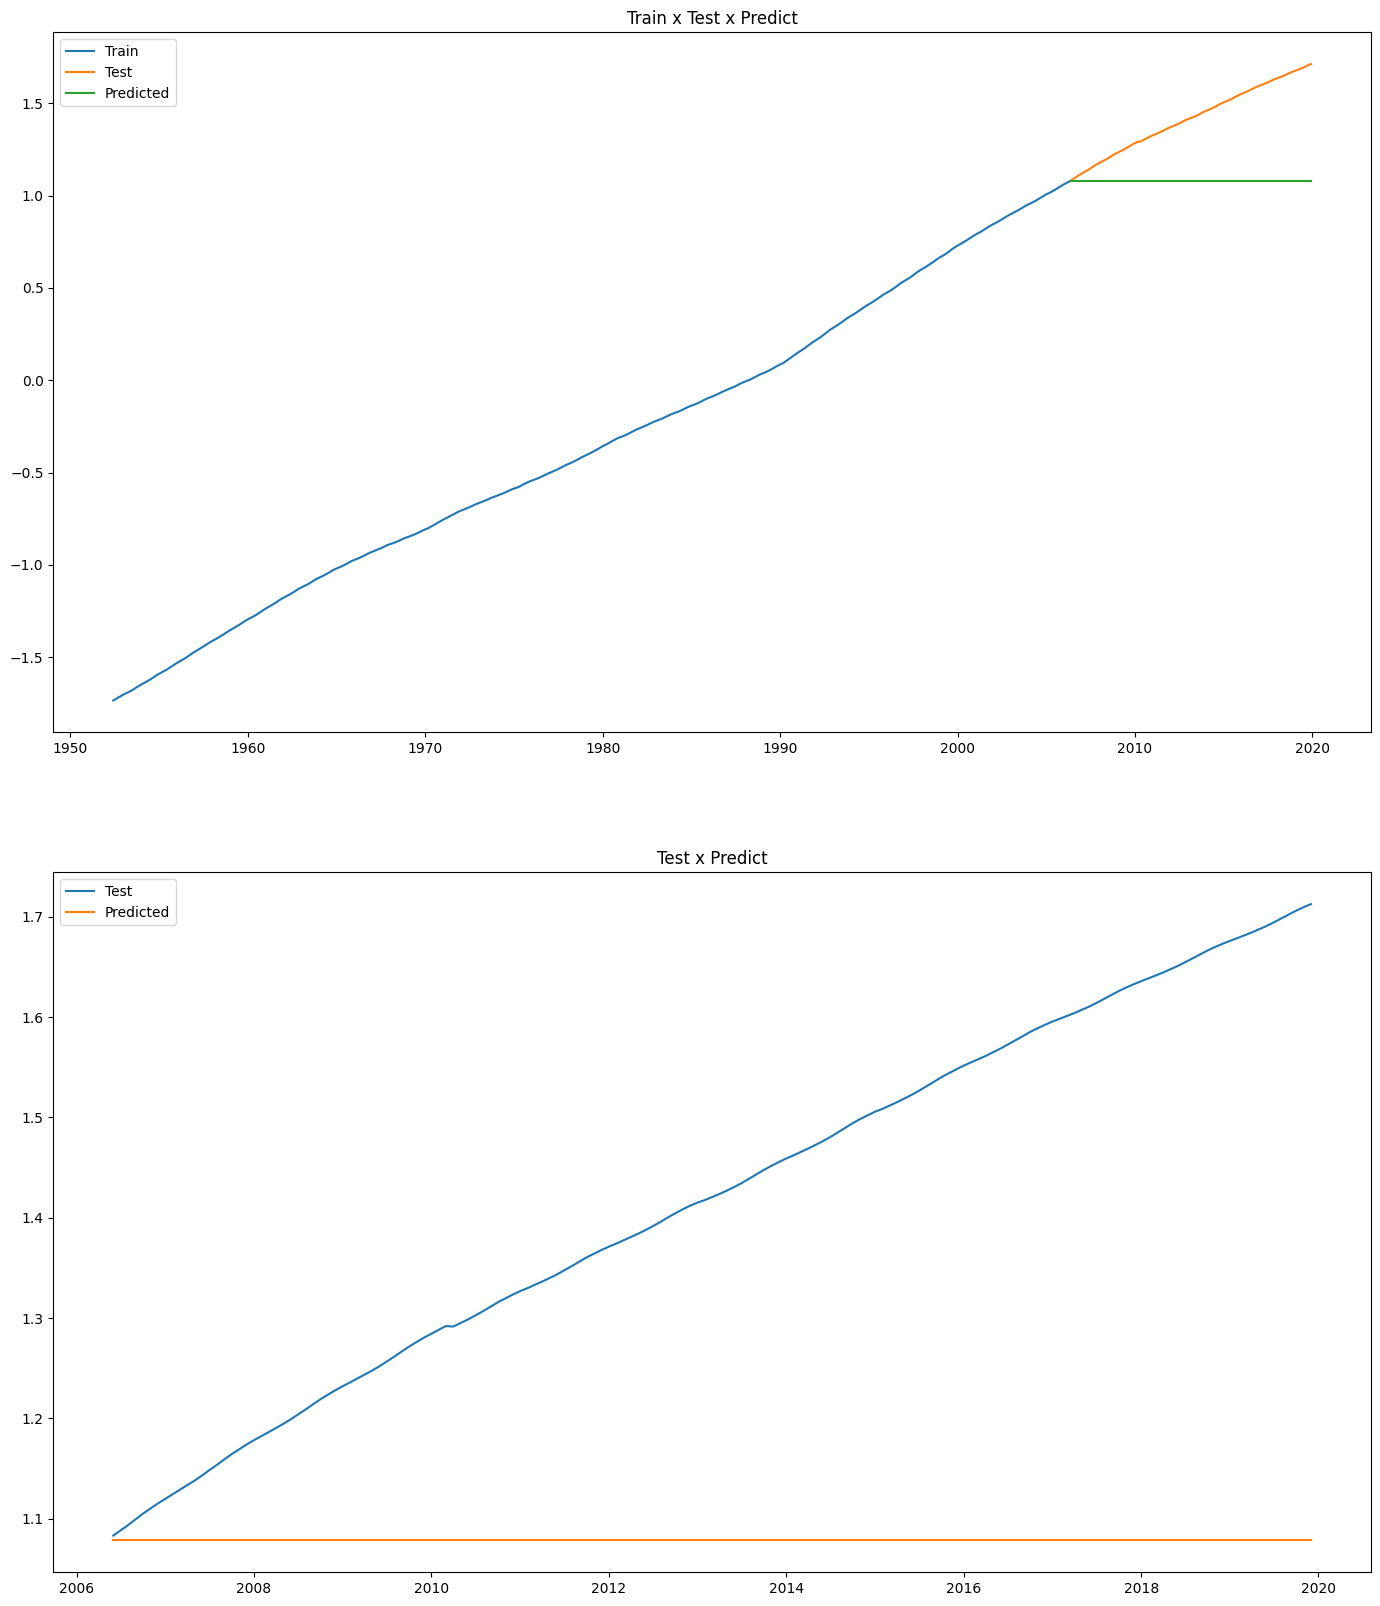

In [31]:
model_decision_tree = DecisionTreeRegressor().fit(x_train.reshape(-1,window), y_train.reshape(-1))
y_predicted = model_decision_tree.predict(x_test.reshape(-1,window)).reshape(-1,1)

results_chart(y_predicted, y_test, y_train, df['date'].to_numpy(), window)

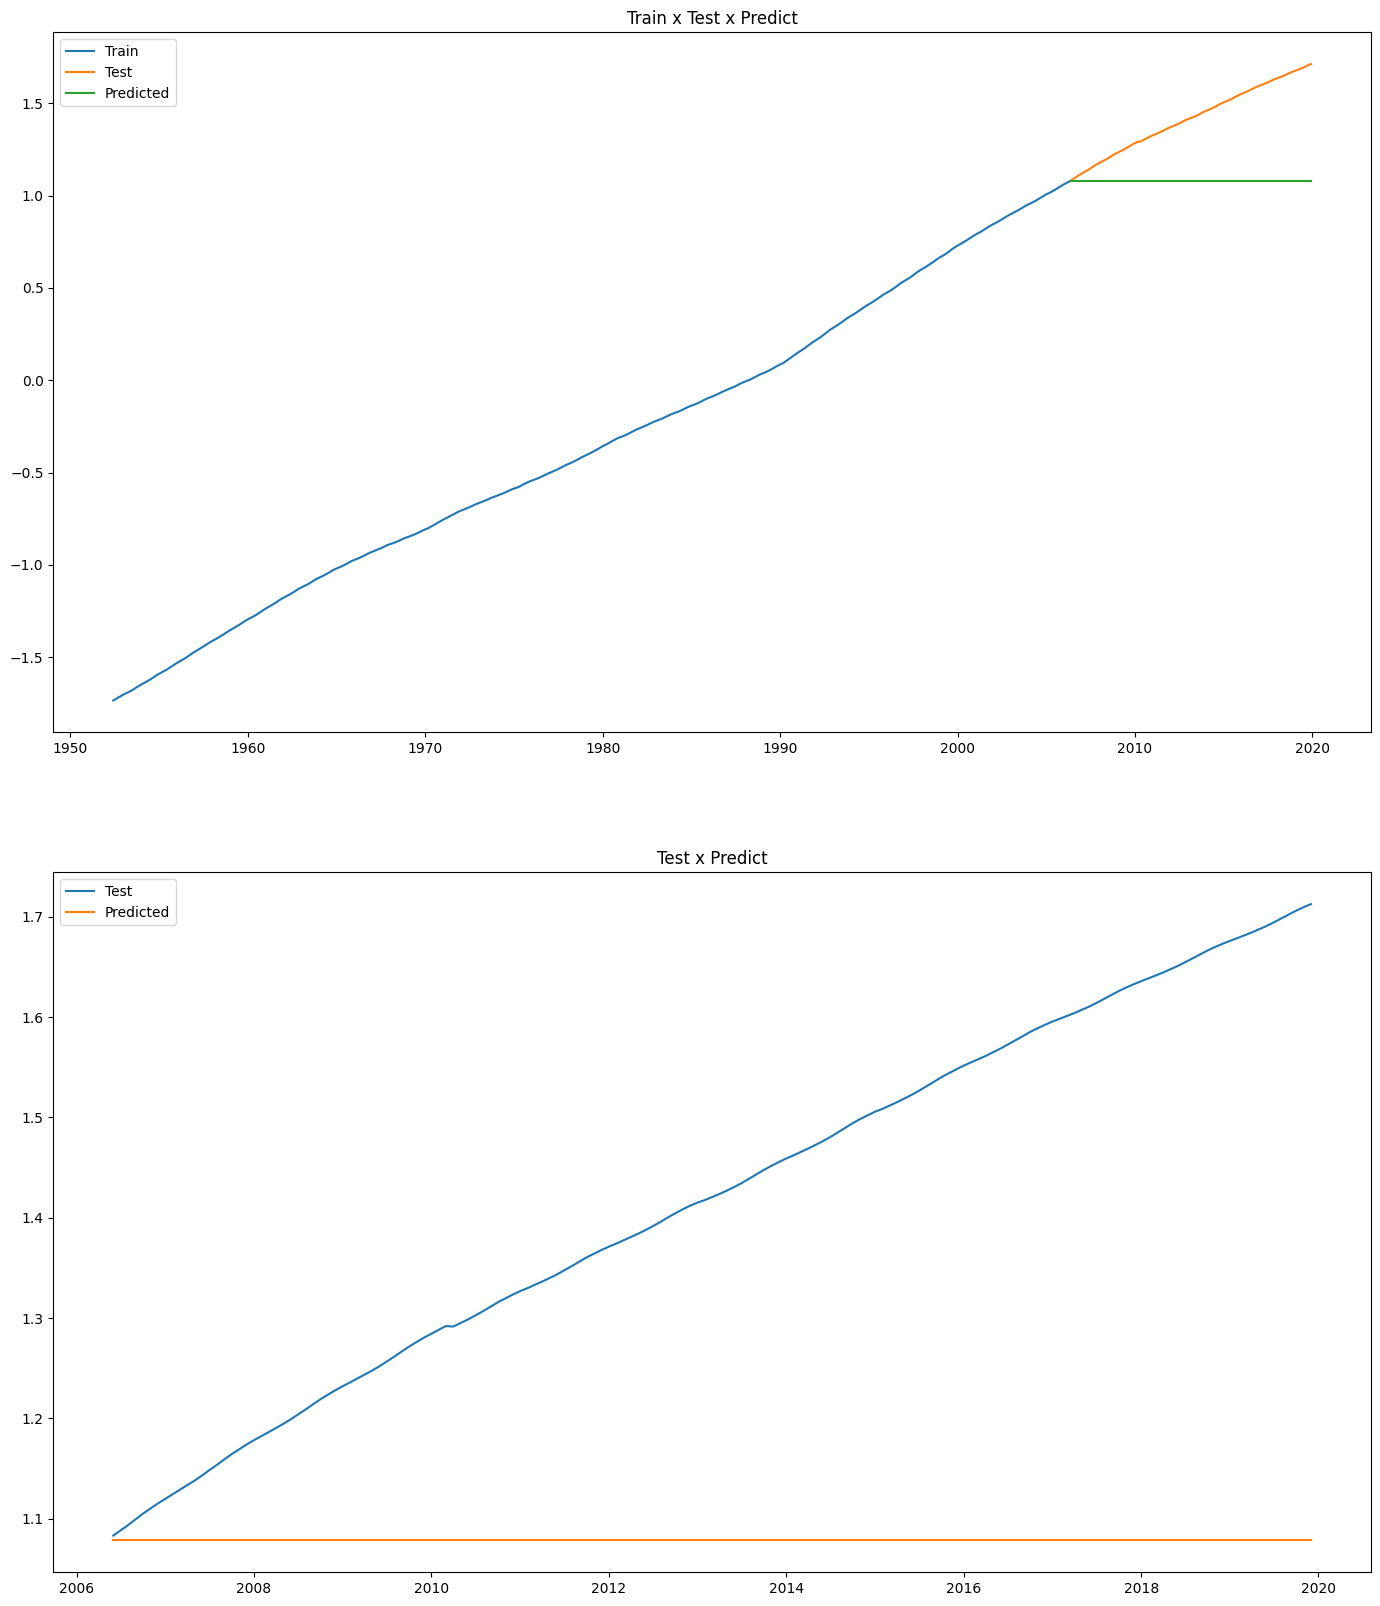

In [34]:
model_decision_tree2 = DecisionTreeRegressor(criterion="friedman_mse").fit(x_train.reshape(-1,window), y_train.reshape(-1))
y_predicted = model_decision_tree2.predict(x_test.reshape(-1,window)).reshape(-1,1)

results_chart(y_predicted, y_test, y_train, df['date'].to_numpy(), window)

Using Grid search CV to see if we can improve the model's prediction

In [35]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to search over
param_grid = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create a decision tree regressor object
dt = DecisionTreeRegressor()

# Create a grid search object
grid_search = GridSearchCV(dt, param_grid=param_grid, cv=5)

# Fit the grid search object to the data
grid_search.fit(x_train.reshape(-1,window), y_train.reshape(-1))

# Print the best hyperparameters and corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.9/dist-pa

Best hyperparameters:  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score:  -1.2270281050361382


Using the best hyperparameters found

max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2

In [36]:
# Create a decision tree regressor object
dt = DecisionTreeRegressor(max_depth=10,max_features="sqrt",min_samples_leaf=1,min_samples_split=2)

In [37]:
dt.fit(x_train.reshape(-1,window), y_train.reshape(-1))

DecisionTreeRegressor(max_depth=10, max_features='sqrt')

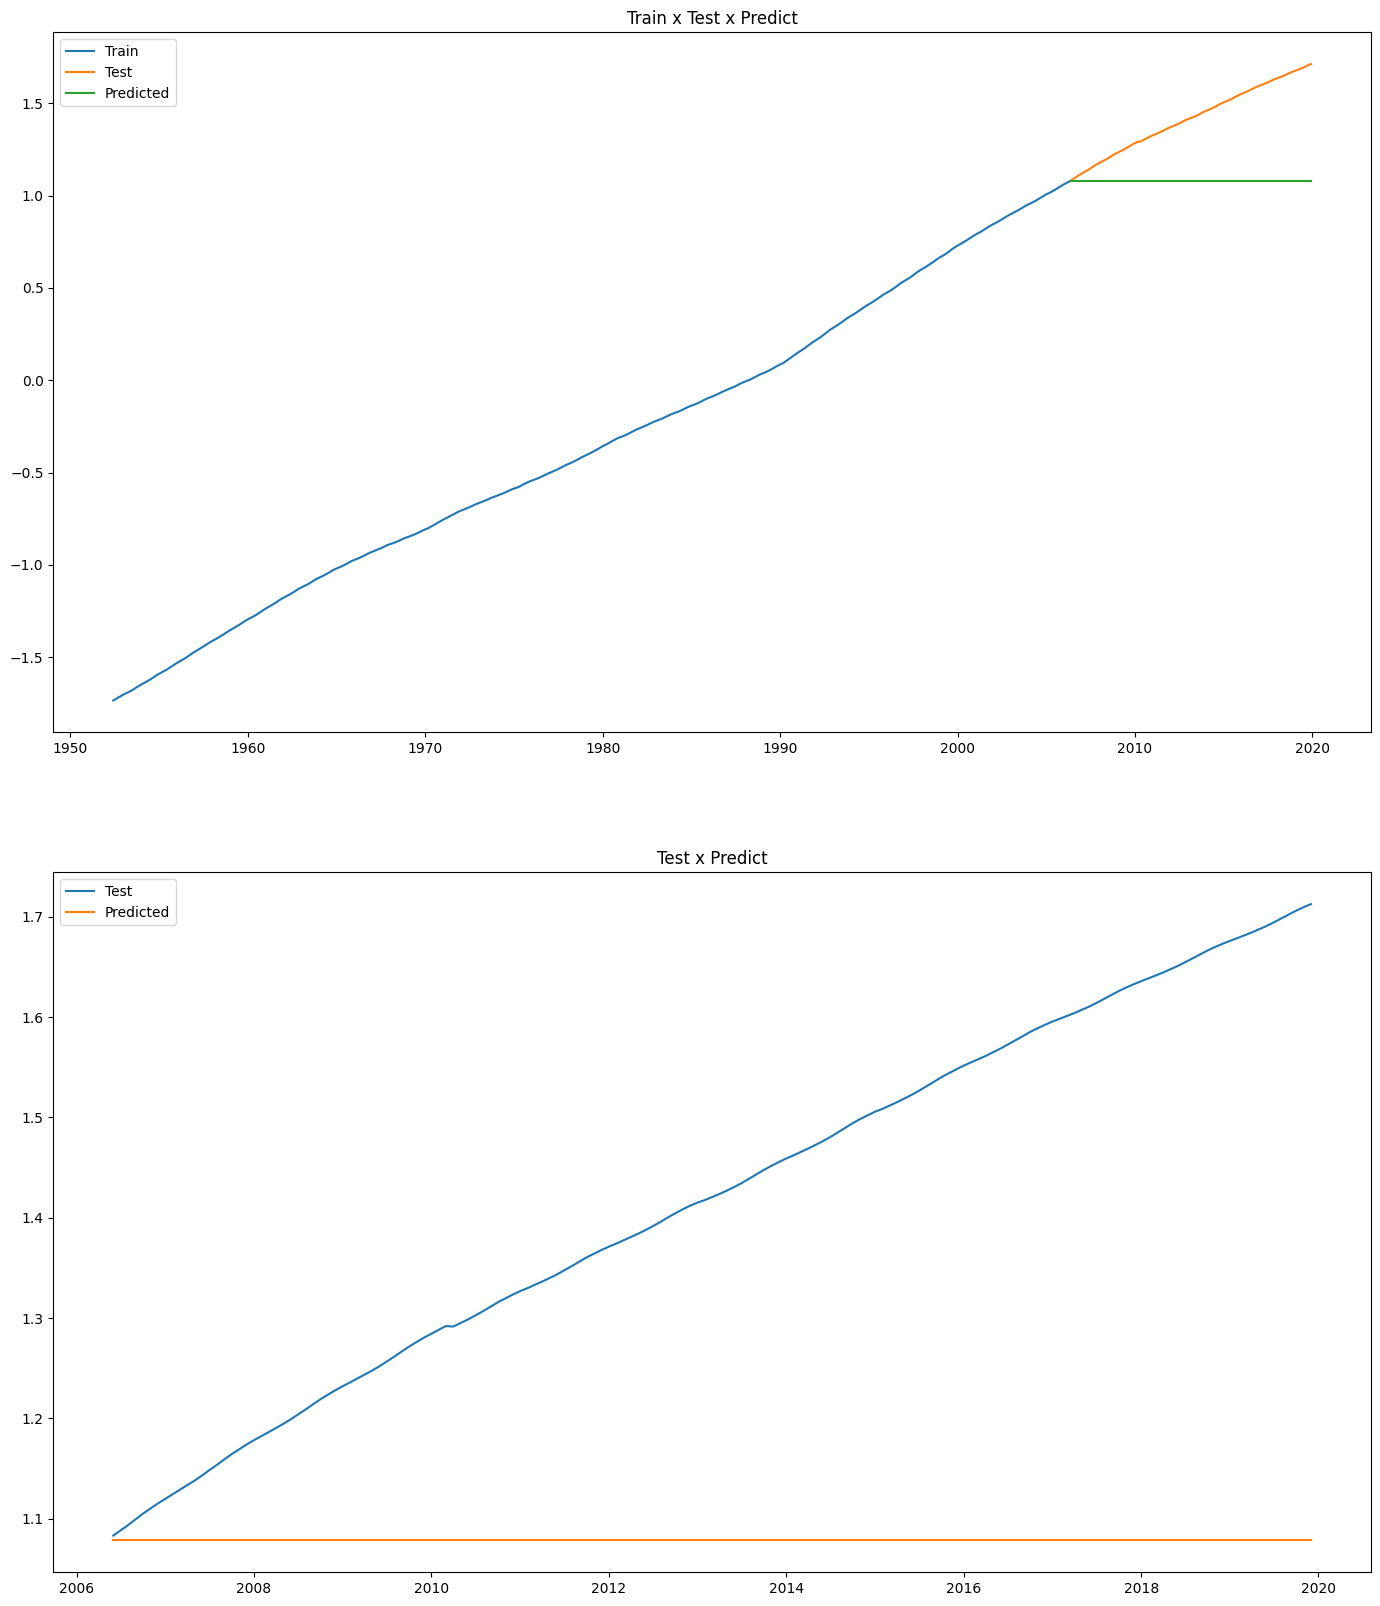

In [38]:
y_predicted = dt.predict(x_test.reshape(-1,window)).reshape(-1,1)

results_chart(y_predicted, y_test, y_train, df['date'].to_numpy(), window)

*No major improvement*

# **Predicting the future**

In [17]:
# Function specific for the lst because of the type of shape
def predict_future_lstm(target, model, window, n=100):
    new_target = target.tolist()
    for i in range(n):
        feature = np.array(new_target[-window:]).reshape(1,window,1)
        target_predicted = model.predict(feature).reshape(1)
        new_target.append(target_predicted)
    return np.array(new_target)

# Generic function for creating our time series with the predicted values
def predict_future(target, model, window, n=100):
    new_target = target.tolist()
    for i in range(n):
        feature = np.array(new_target[-window:]).reshape(-1,window)
        target_predicted = model.predict(feature).reshape(1)
        new_target.append(target_predicted)
    return np.array(new_target)

In [ ]:
# n is the number of units of time that i'm predicting
n = 100
target_model_scaled = predict_future_lstm(target_scaled, model, window, n=n)
target_model_linear_scaled = predict_future(target_scaled,model_linear_reg,window,n=n)
target_model_decision_tree_scaled = predict_future(target_scaled,model_decision_tree,window,n=n)
target_model_svr_scaled = predict_future(target_scaled,model_svr,window,n=n)
target_model_sdgr_scaled = predict_future(target_scaled,model_sdgr,window,n=n)

In [41]:
# Create the extra date to visualize in the chart 
extra_dates = pd.date_range(df['date'].iloc[-1], periods=n + 1, freq='MS')
extra_dates = extra_dates.to_series().reset_index(drop=True).iloc[1:]
all_dates = pd.concat((df['date'], extra_dates), ignore_index=True)

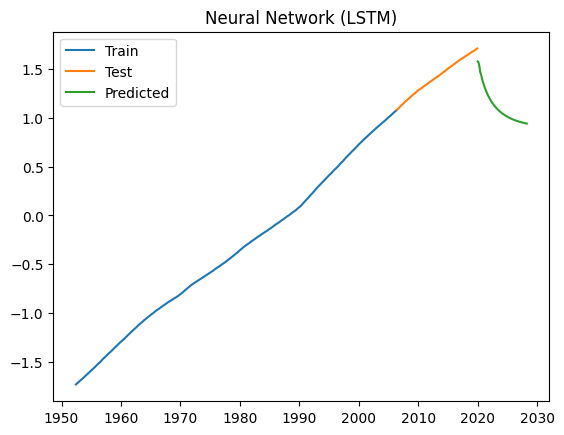

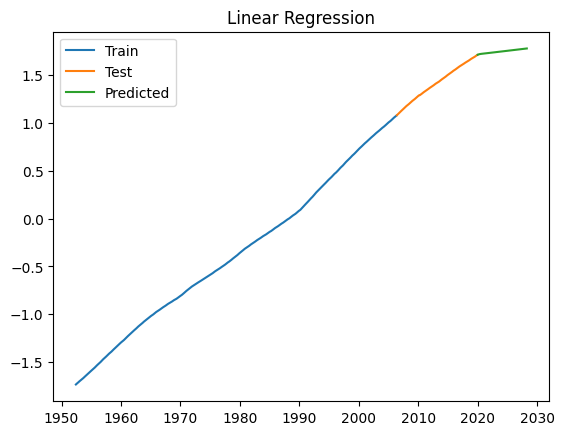

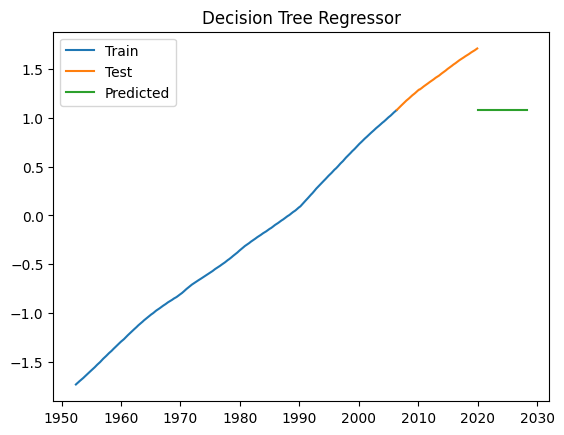

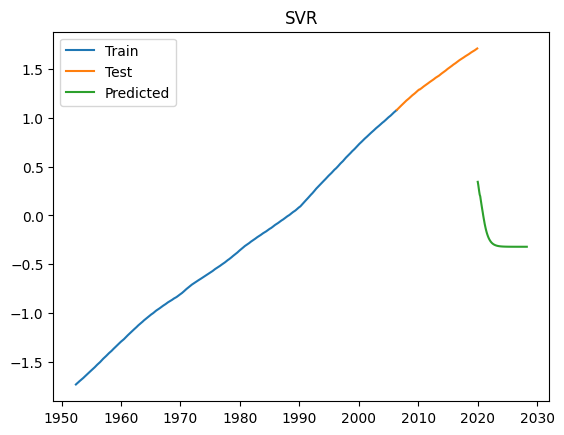

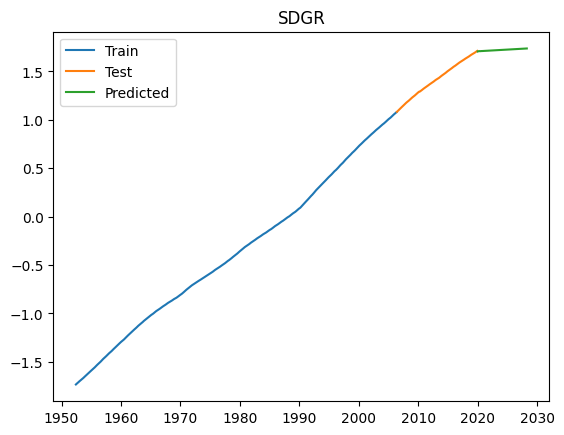

In [42]:
# Function to show the train, test and prediction values
def future_chart(future_target, y_train, y_test, x_date, window, title=''):
    original_target_size = len(y_train) + len(y_test)
    sns.lineplot(x=x_date[window:len(y_train) + window], y=y_train[:,0], label='Train')
    sns.lineplot(x=x_date[len(y_train) + window: original_target_size + window], y=y_test[:,0], label='Test')
    sns.lineplot(x=x_date[original_target_size + window:], y=future_target[original_target_size:,0], label='Predicted')
    plt.title(label=title)
    plt.show()

future_chart(target_model_scaled,  y_train, y_test, all_dates, window, title='Neural Network (LSTM)')
future_chart(target_model_linear_scaled,  y_train, y_test, all_dates, window, title='Linear Regression')
future_chart(target_model_decision_tree_scaled,  y_train, y_test, all_dates, window, title='Decision Tree Regressor')
future_chart(target_model_svr_scaled,  y_train, y_test, all_dates, window, title='SVR')
future_chart(target_model_sdgr_scaled,  y_train, y_test, all_dates, window, title='SDGR')

We can see that LSTM performed poorly than Linear regression model, let's try to improve LSTM

1. Increase the number of LSTM units:

In [43]:
model1 = keras.Sequential()
model1.add(keras.layers.LSTM(256,input_shape=(x_train.shape[1],x_train.shape[2])))
model1.add(keras.layers.Dense(units=1))
model1.compile(loss="mean_squared_error",optimizer = "RMSProp")


Epoch 1/10
21/21 [==============================] - 5s 62ms/step - loss: 0.1055 - val_loss: 0.0084
Epoch 2/10
21/21 [==============================] - 1s 38ms/step - loss: 4.2716e-04 - val_loss: 0.0628
Epoch 3/10
21/21 [==============================] - 1s 36ms/step - loss: 0.0026 - val_loss: 0.0056
Epoch 4/10
21/21 [==============================] - 1s 36ms/step - loss: 0.0027 - val_loss: 0.0040
Epoch 5/10
21/21 [==============================] - 1s 25ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 6/10
21/21 [==============================] - 1s 24ms/step - loss: 0.0032 - val_loss: 0.0044
Epoch 7/10
21/21 [==============================] - 1s 25ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 8/10
21/21 [==============================] - 1s 24ms/step - loss: 0.0013 - val_loss: 0.0052
Epoch 9/10
21/21 [==============================] - 1s 26ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 10/10
6/6 [==============================] - 0s 7ms/step


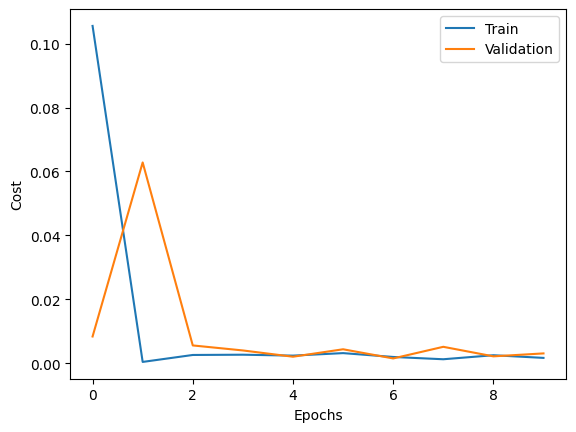

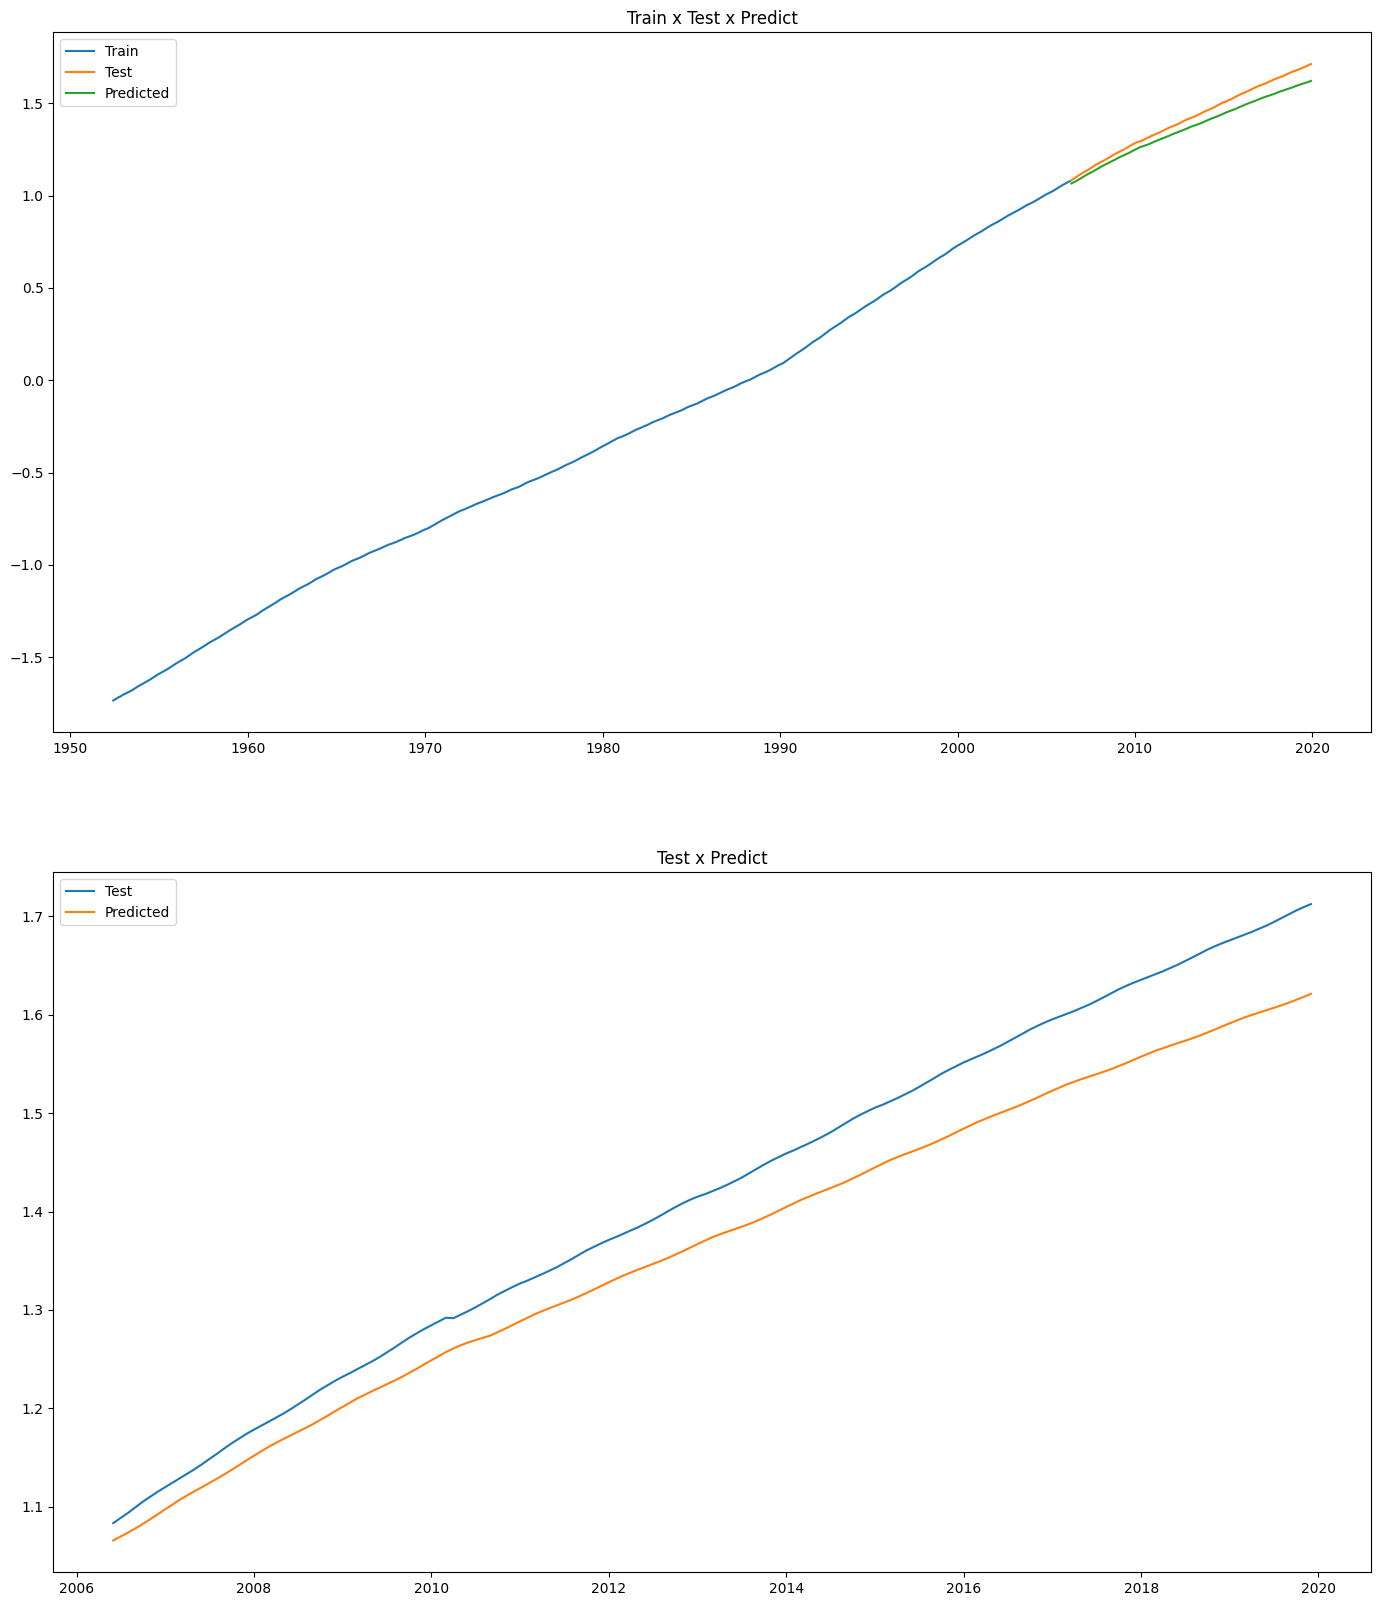

In [44]:
result = model1.fit(x_train,y_train,validation_data=(x_test,y_test),
                   epochs=10)
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(['Train','Validation'])
plt.xlabel('Epochs')
plt.ylabel('Cost')

y_predicted = model1.predict(x_test)
results_chart(y_predicted, y_test, y_train, df['date'].to_numpy(), window)

2. Add more LSTM layers:


In [45]:
model2 = keras.Sequential()
model2.add(keras.layers.LSTM(128,return_sequences=True,input_shape=(x_train.shape[1],x_train.shape[2])))
model2.add(keras.layers.LSTM(64))
model2.add(keras.layers.Dense(units=1))
model2.compile(loss="mean_squared_error",optimizer = "RMSProp")


Epoch 1/10
21/21 [==============================] - 11s 64ms/step - loss: 0.1027 - val_loss: 0.0257
Epoch 2/10
21/21 [==============================] - 0s 18ms/step - loss: 0.0017 - val_loss: 0.0157
Epoch 3/10
21/21 [==============================] - 0s 19ms/step - loss: 0.0035 - val_loss: 0.0160
Epoch 4/10
21/21 [==============================] - 0s 22ms/step - loss: 0.0024 - val_loss: 0.0112
Epoch 5/10
21/21 [==============================] - 0s 20ms/step - loss: 0.0027 - val_loss: 0.0183
Epoch 6/10
21/21 [==============================] - 0s 23ms/step - loss: 0.0028 - val_loss: 0.0157
Epoch 7/10
21/21 [==============================] - 0s 18ms/step - loss: 0.0019 - val_loss: 0.0742
Epoch 8/10
21/21 [==============================] - 0s 22ms/step - loss: 0.0025 - val_loss: 0.0332
Epoch 9/10
21/21 [==============================] - 0s 20ms/step - loss: 0.0033 - val_loss: 0.0225
Epoch 10/10
6/6 [==============================] - 1s 7ms/step


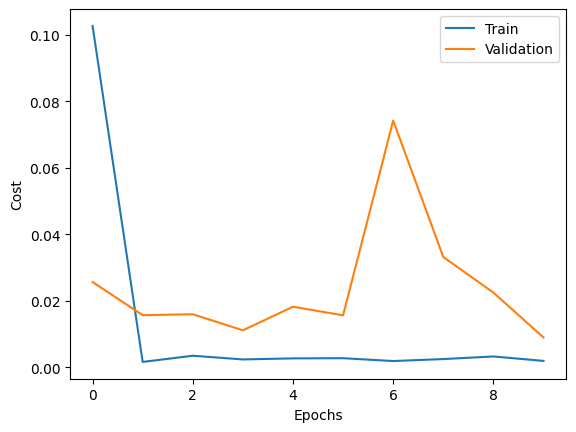

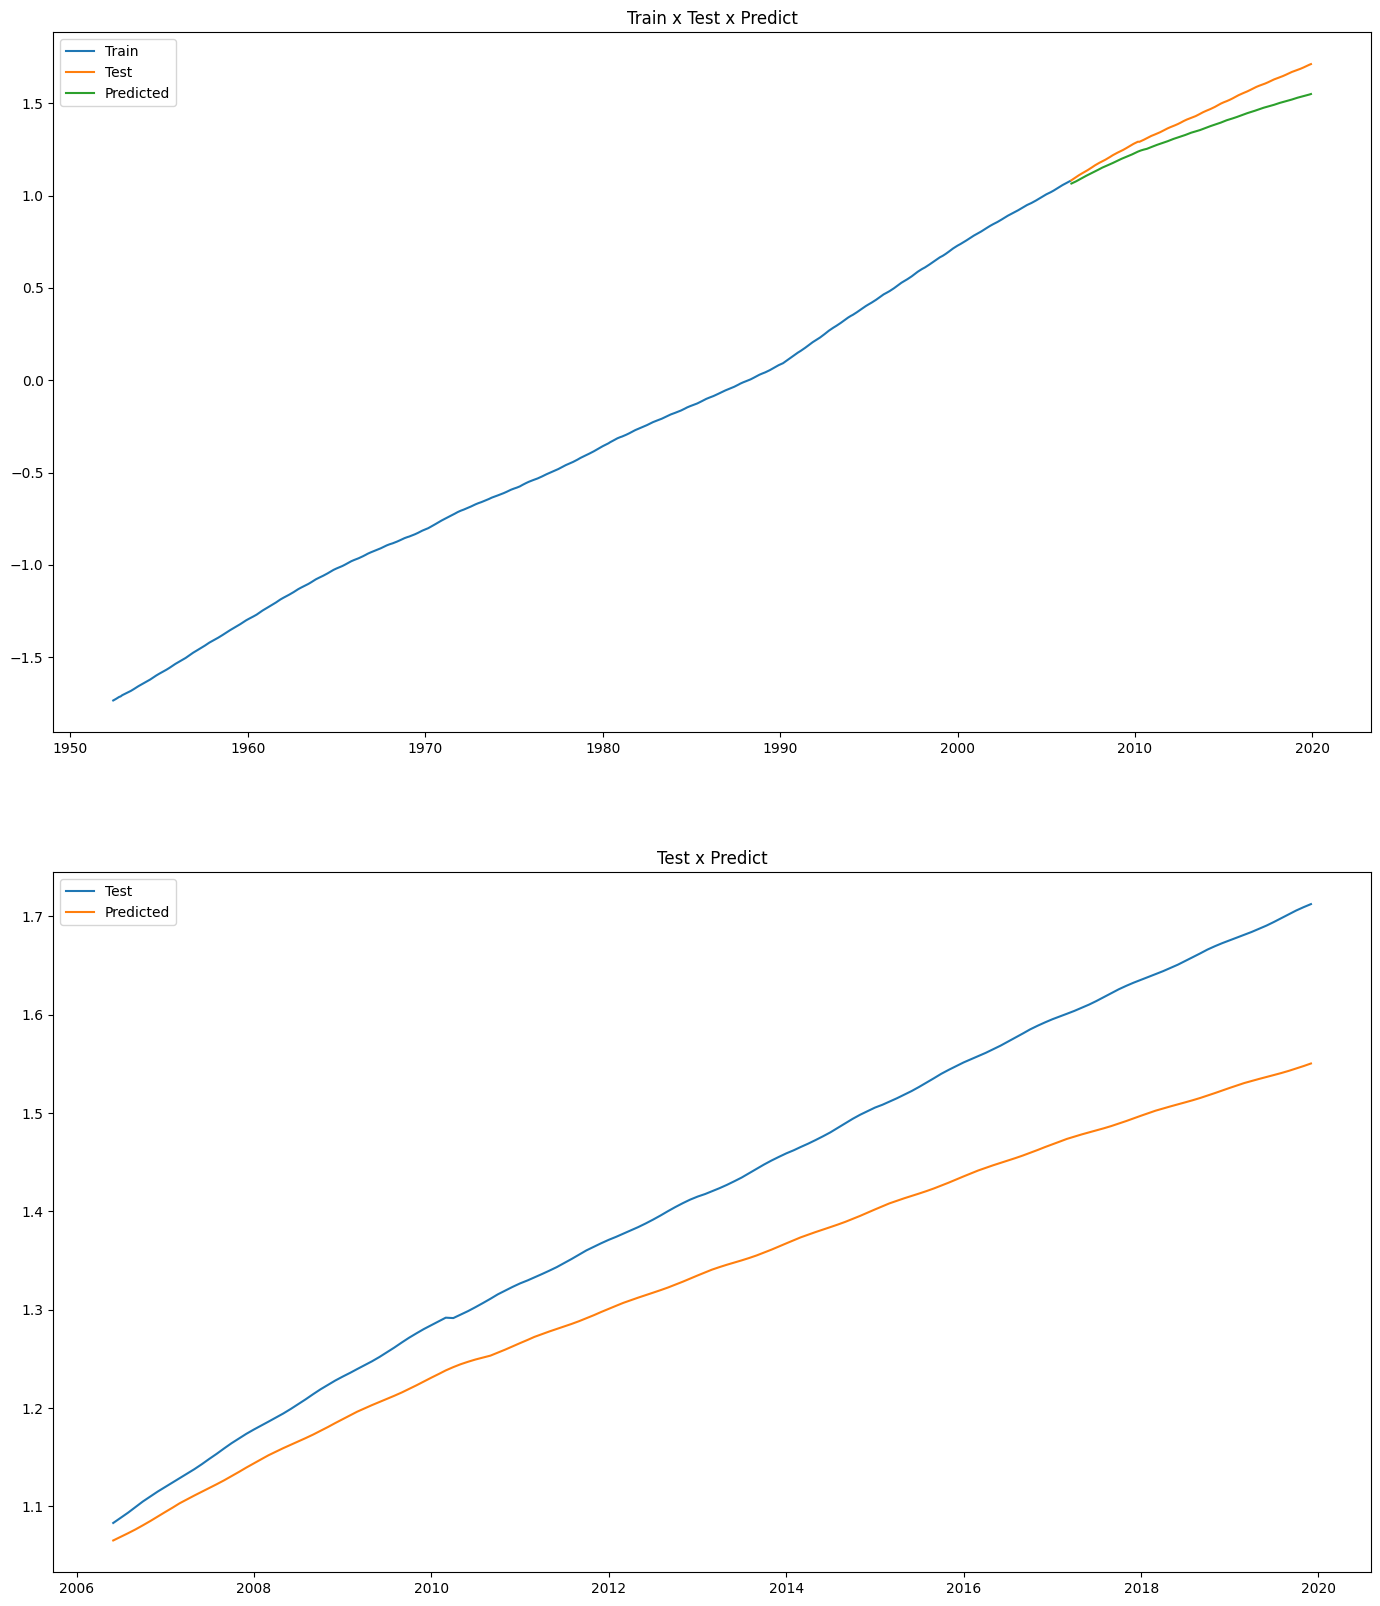

In [46]:
result = model2.fit(x_train,y_train,validation_data=(x_test,y_test),
                   epochs=10)
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(['Train','Validation'])
plt.xlabel('Epochs')
plt.ylabel('Cost')

y_predicted = model2.predict(x_test)
results_chart(y_predicted, y_test, y_train, df['date'].to_numpy(), window)

3. Try different activation functions:


In [18]:
model3 = keras.Sequential()
model3.add(keras.layers.LSTM(128,activation="relu",input_shape=(x_train.shape[1],x_train.shape[2])))
model3.add(keras.layers.Dense(units=1))
model3.compile(loss="mean_squared_error",optimizer = "RMSProp")


Epoch 1/10
21/21 [==============================] - 2s 25ms/step - loss: 0.2810 - val_loss: 0.4952
Epoch 2/10
21/21 [==============================] - 0s 13ms/step - loss: 0.0085 - val_loss: 0.0192
Epoch 3/10
21/21 [==============================] - 0s 12ms/step - loss: 0.0015 - val_loss: 0.0193
Epoch 4/10
21/21 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0074
Epoch 5/10
21/21 [==============================] - 0s 12ms/step - loss: 8.7787e-04 - val_loss: 6.5405e-04
Epoch 6/10
21/21 [==============================] - 0s 15ms/step - loss: 0.0011 - val_loss: 3.6143e-04
Epoch 7/10
21/21 [==============================] - 0s 20ms/step - loss: 8.7690e-04 - val_loss: 7.4805e-04
Epoch 8/10
21/21 [==============================] - 0s 19ms/step - loss: 9.6048e-04 - val_loss: 0.0026
Epoch 9/10
21/21 [==============================] - 0s 19ms/step - loss: 5.6546e-04 - val_loss: 0.0019
Epoch 10/10
6/6 [==============================] - 0s 7ms/step


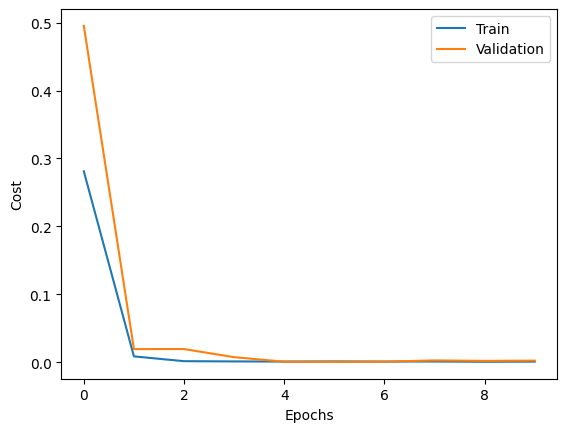

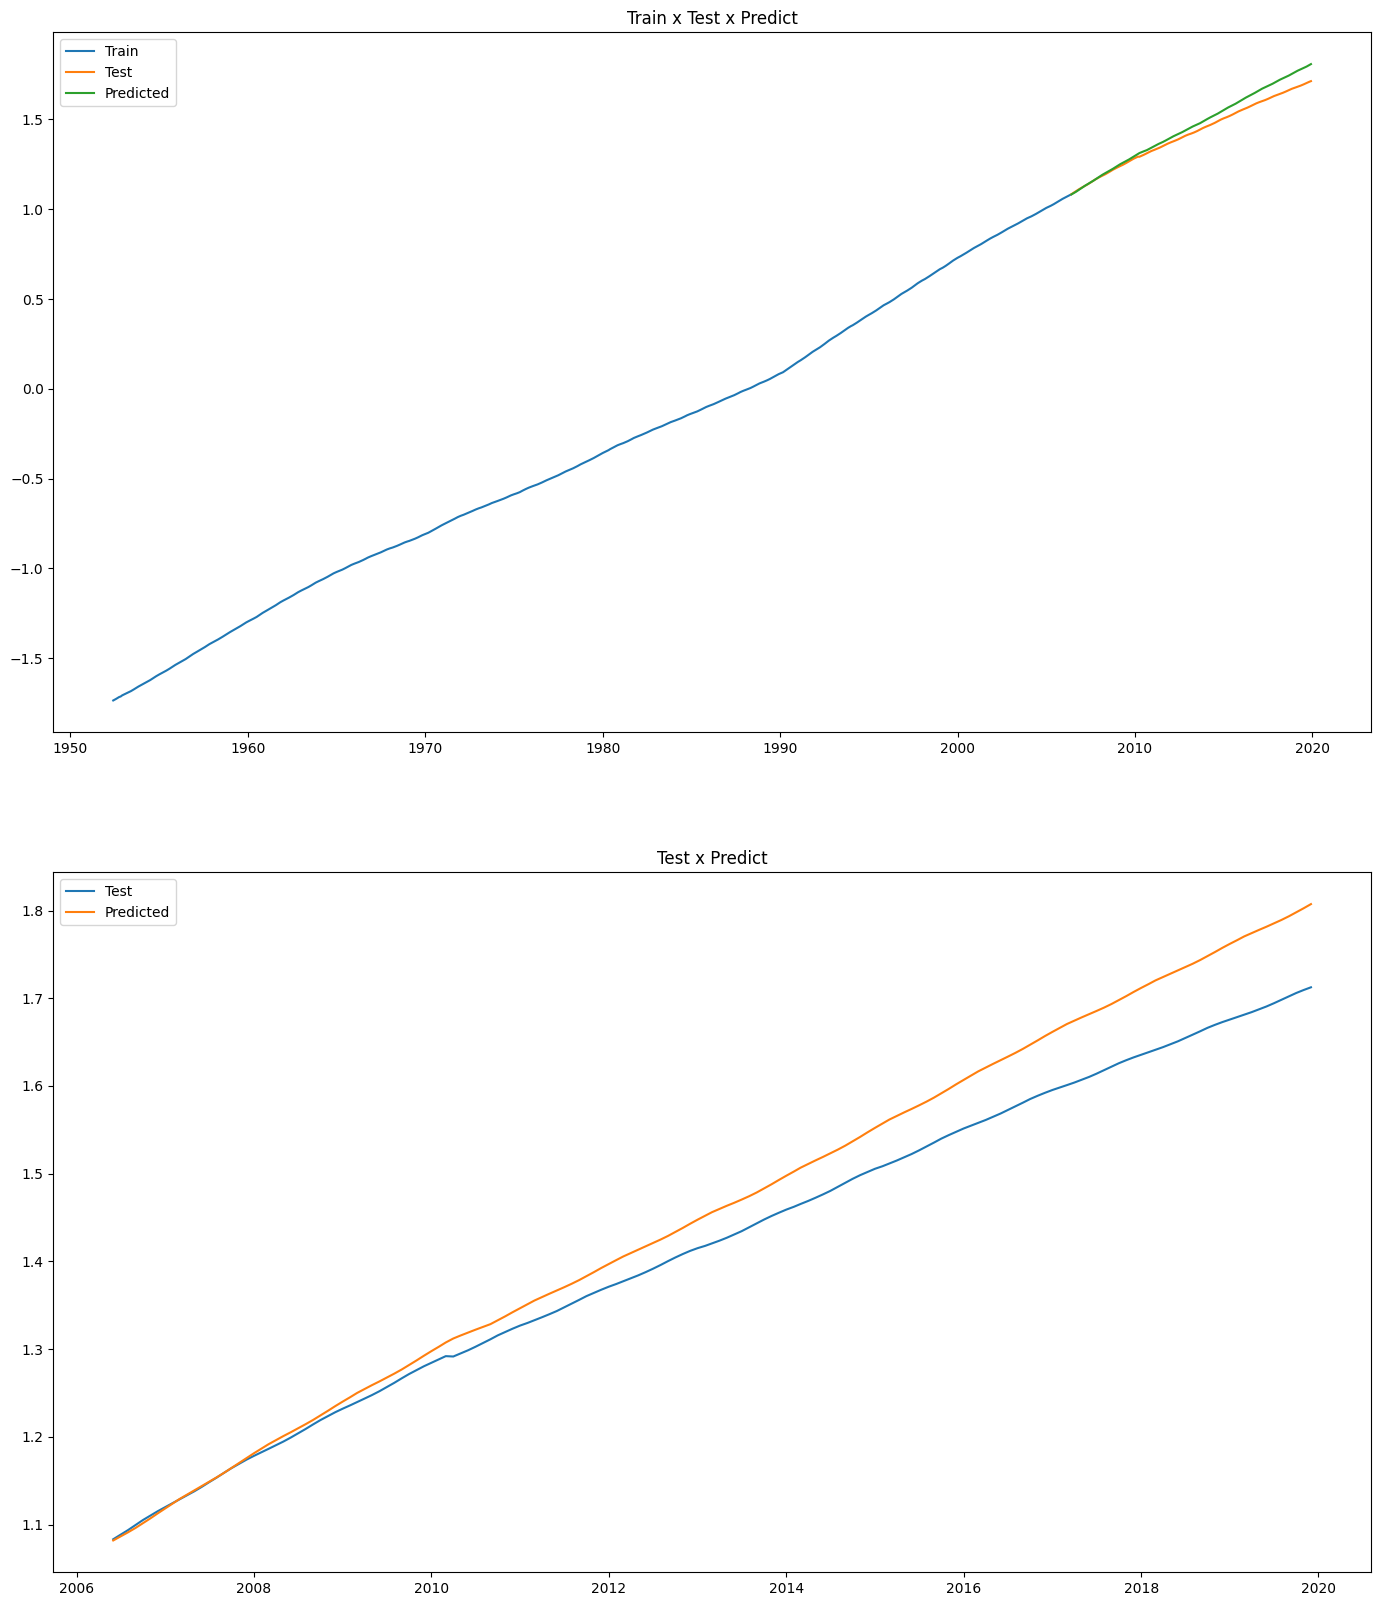

In [19]:
result = model3.fit(x_train,y_train,validation_data=(x_test,y_test),
                   epochs=10)
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(['Train','Validation'])
plt.xlabel('Epochs')
plt.ylabel('Cost')

y_predicted = model3.predict(x_test)
results_chart(y_predicted, y_test, y_train, df['date'].to_numpy(), window)

4. Add regularization:


In [49]:
model4 = keras.Sequential()
model4.add(keras.layers.LSTM(128,input_shape=(x_train.shape[1],x_train.shape[2]),kernel_regularizer=keras.regularizers.l2(0.01)))
model4.add(keras.layers.Dropout(0.2))
model4.add(keras.layers.Dense(units=1))
model4.compile(loss="mean_squared_error",optimizer = "RMSProp")


Epoch 1/10
21/21 [==============================] - 5s 44ms/step - loss: 0.1853 - val_loss: 0.0818
Epoch 2/10
21/21 [==============================] - 0s 16ms/step - loss: 0.0171 - val_loss: 0.0339
Epoch 3/10
21/21 [==============================] - 0s 20ms/step - loss: 0.0133 - val_loss: 0.0442
Epoch 4/10
21/21 [==============================] - 1s 50ms/step - loss: 0.0115 - val_loss: 0.0117
Epoch 5/10
21/21 [==============================] - 1s 43ms/step - loss: 0.0084 - val_loss: 0.0201
Epoch 6/10
21/21 [==============================] - 0s 22ms/step - loss: 0.0083 - val_loss: 0.0351
Epoch 7/10
21/21 [==============================] - 0s 21ms/step - loss: 0.0068 - val_loss: 0.0139
Epoch 8/10
21/21 [==============================] - 0s 22ms/step - loss: 0.0066 - val_loss: 0.0100
Epoch 9/10
21/21 [==============================] - 0s 15ms/step - loss: 0.0068 - val_loss: 0.0043
Epoch 10/10
6/6 [==============================] - 0s 5ms/step


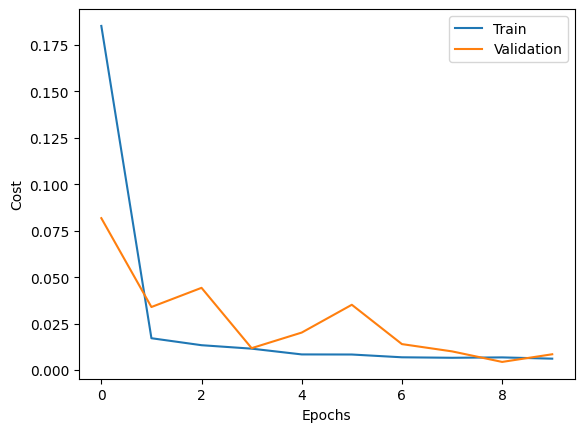

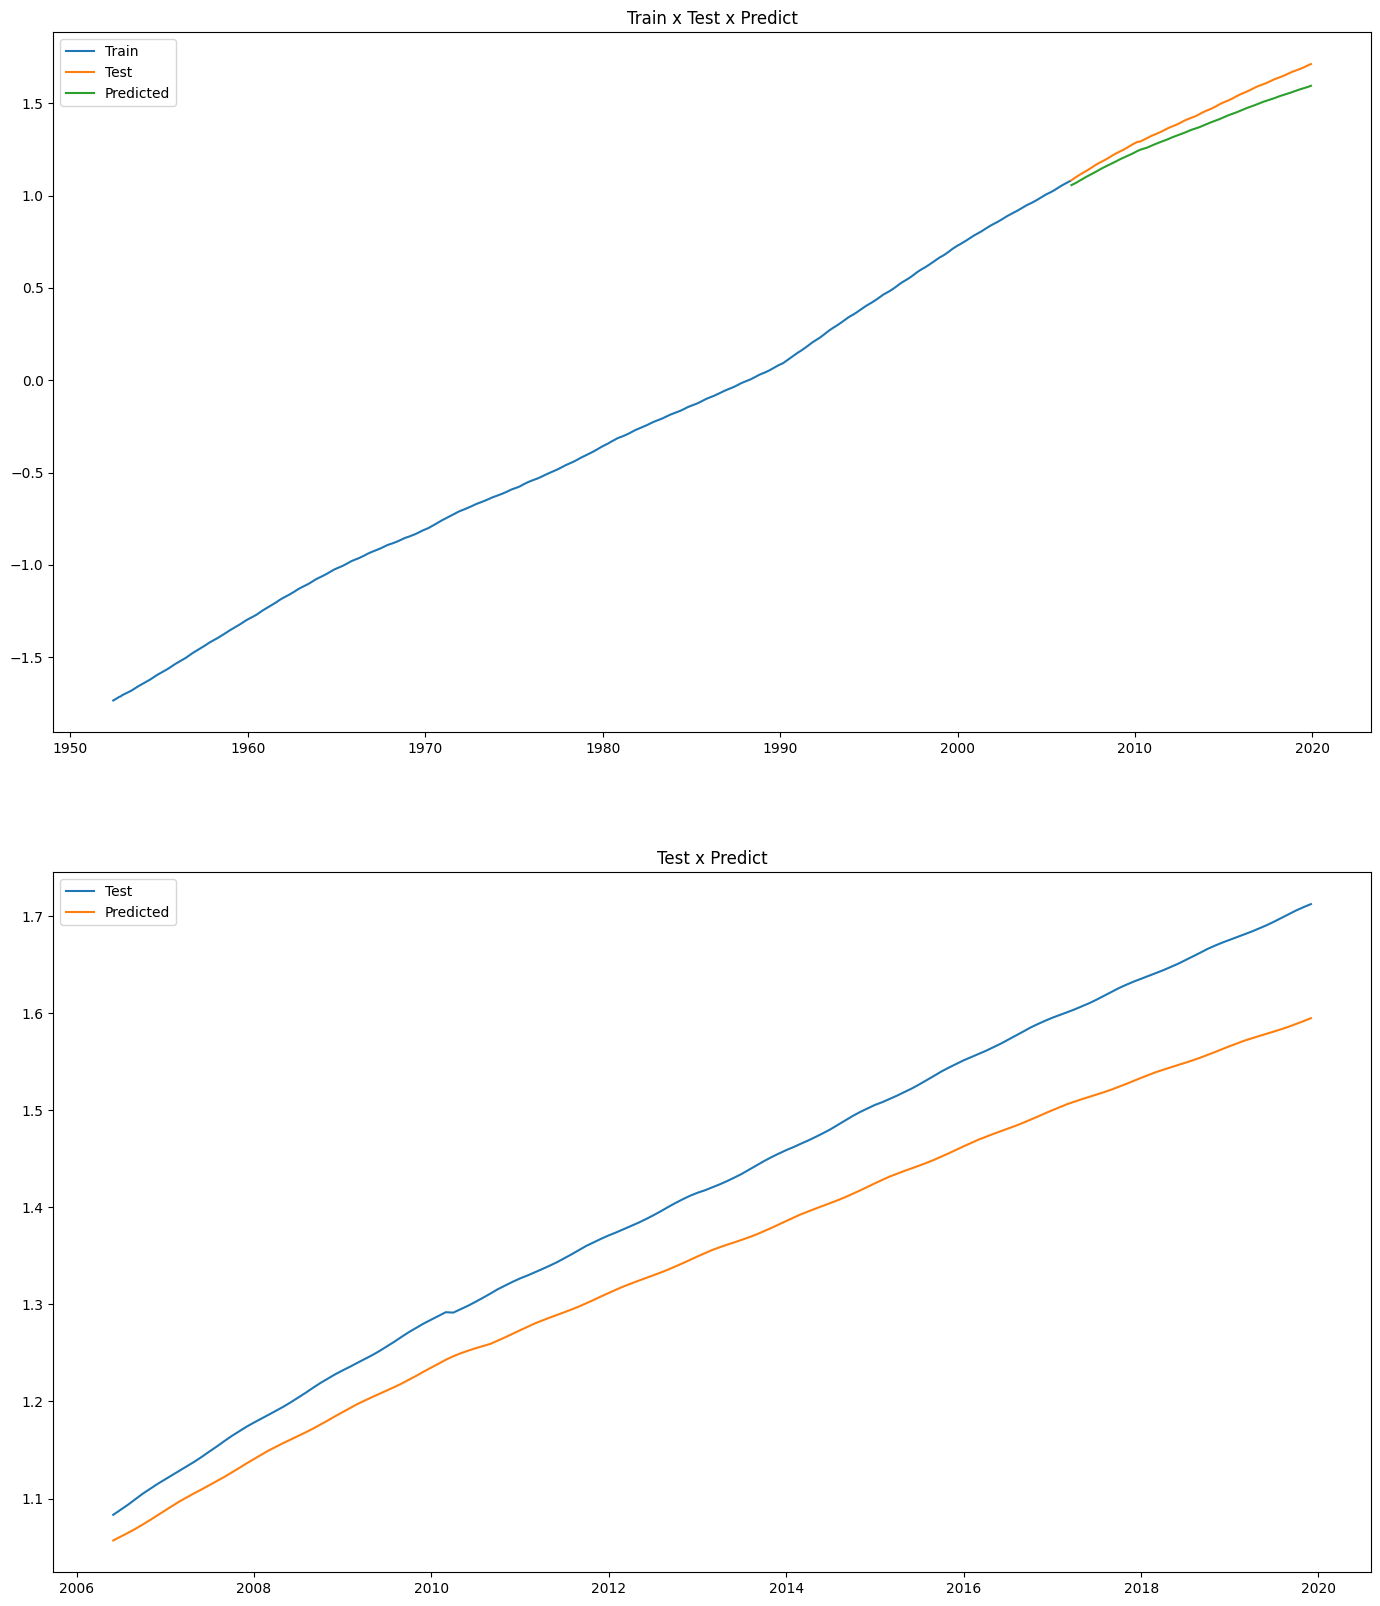

In [50]:
result = model4.fit(x_train,y_train,validation_data=(x_test,y_test),
                   epochs=10)
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(['Train','Validation'])
plt.xlabel('Epochs')
plt.ylabel('Cost')

y_predicted = model4.predict(x_test)
results_chart(y_predicted, y_test, y_train, df['date'].to_numpy(), window)

5. Try a different optimizer:


In [51]:
model5 = keras.Sequential()
model5.add(keras.layers.LSTM(128,input_shape=(x_train.shape[1],x_train.shape[2])))
model5.add(keras.layers.Dense(units=1))
model5.compile(loss="mean_squared_error",optimizer = "Adam")


Epoch 1/10
21/21 [==============================] - 5s 42ms/step - loss: 0.1775 - val_loss: 0.1081
Epoch 2/10
21/21 [==============================] - 0s 15ms/step - loss: 0.0078 - val_loss: 0.0013
Epoch 3/10
21/21 [==============================] - 0s 15ms/step - loss: 0.0012 - val_loss: 0.0086
Epoch 4/10
21/21 [==============================] - 0s 14ms/step - loss: 2.5688e-04 - val_loss: 0.0078
Epoch 5/10
21/21 [==============================] - 0s 13ms/step - loss: 1.3850e-04 - val_loss: 0.0057
Epoch 6/10
21/21 [==============================] - 0s 14ms/step - loss: 1.2616e-04 - val_loss: 0.0066
Epoch 7/10
21/21 [==============================] - 0s 15ms/step - loss: 1.1678e-04 - val_loss: 0.0067
Epoch 8/10
21/21 [==============================] - 0s 17ms/step - loss: 1.1551e-04 - val_loss: 0.0068
Epoch 9/10
21/21 [==============================] - 0s 14ms/step - loss: 1.1242e-04 - val_loss: 0.0062
Epoch 10/10
6/6 [==============================] - 0s 5ms/step


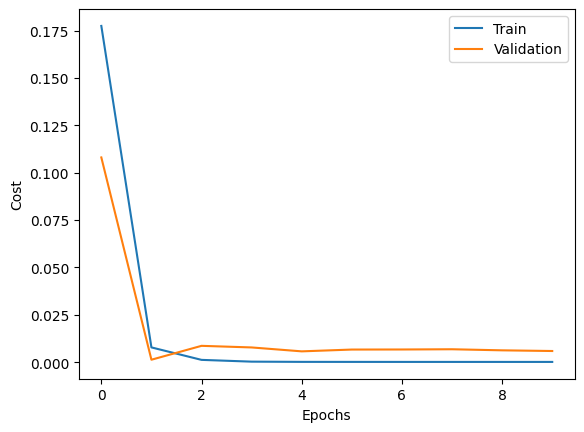

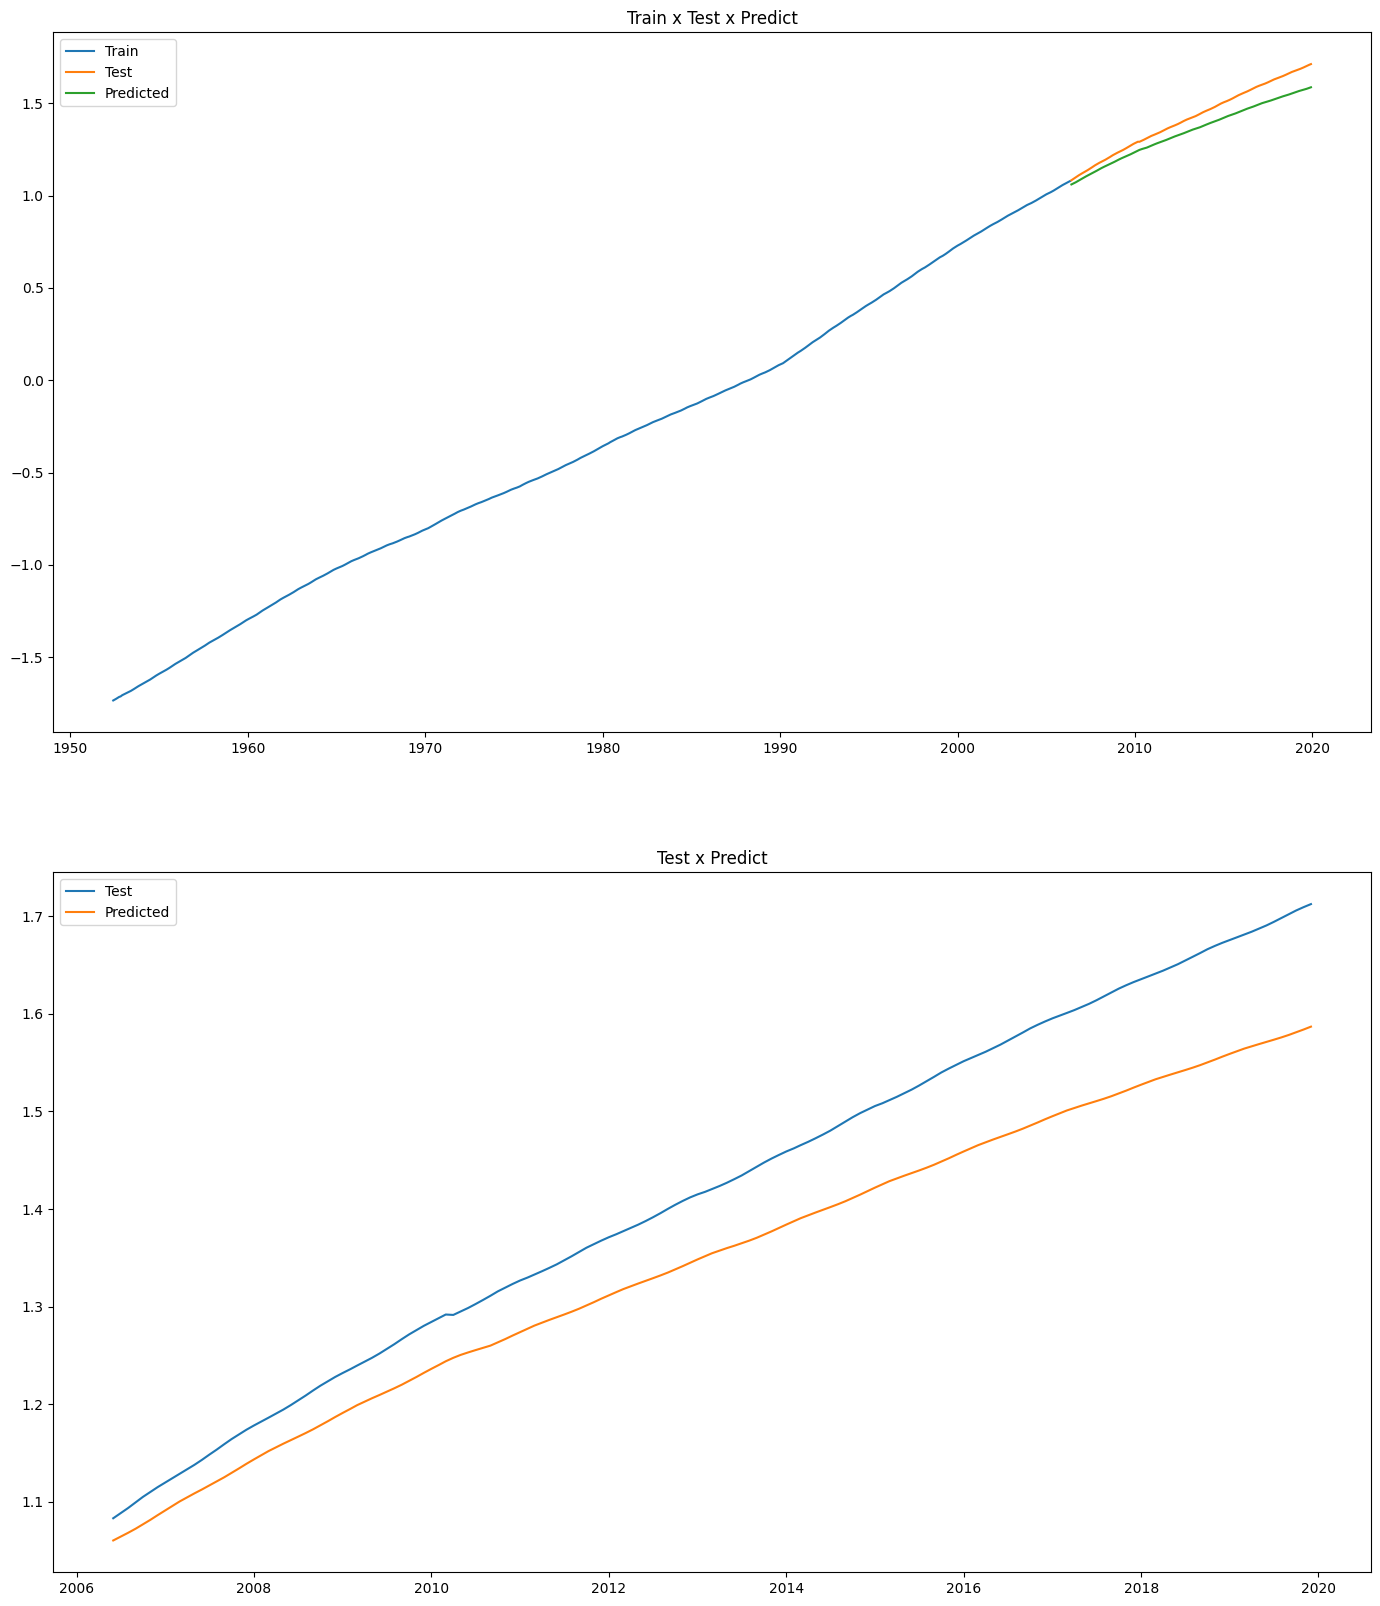

In [52]:
result = model5.fit(x_train,y_train,validation_data=(x_test,y_test),
                   epochs=10)
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(['Train','Validation'])
plt.xlabel('Epochs')
plt.ylabel('Cost')

y_predicted = model5.predict(x_test)
results_chart(y_predicted, y_test, y_train, df['date'].to_numpy(), window)

6. Tune Hyperparameter

In [53]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

def create_model(learning_rate=0.01):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(128,input_shape=(x_train.shape[1],x_train.shape[2])))
    model.add(keras.layers.Dense(units=1))
    optimizer = keras.optimizers.RMSprop(lr=learning_rate)
    model.compile(loss="mean_squared_error", optimizer=optimizer)
    return model

model = KerasRegressor(build_fn=create_model, verbose=0)
param_grid = {'learning_rate': [0.001, 0.01, 0.1, 0.2]}
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(x_train, y_train)


<ipython-input-53-2d7f56faed6f>:12: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


In [54]:

# Print the best hyperparameters and corresponding score
print("Best hyperparameters: ", grid_result.best_params_)
print("Best score: ", grid_result.best_score_)

Best hyperparameters:  {'learning_rate': 0.01}
Best score:  -0.044007584467181005


In [58]:
# Update the learning rate of the optimizer
model7 = keras.Sequential()
model7.add(keras.layers.LSTM(128,input_shape=(x_train.shape[1],x_train.shape[2])))
model7.add(keras.layers.Dense(units=1))

optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
model7.compile(loss="mean_squared_error", optimizer=optimizer)


Epoch 1/10
21/21 [==============================] - 4s 41ms/step - loss: 0.1473 - val_loss: 0.0660
Epoch 2/10
21/21 [==============================] - 0s 13ms/step - loss: 5.7472e-04 - val_loss: 0.0314
Epoch 3/10
21/21 [==============================] - 0s 13ms/step - loss: 0.0015 - val_loss: 0.0239
Epoch 4/10
21/21 [==============================] - 0s 15ms/step - loss: 9.2786e-04 - val_loss: 0.0048
Epoch 5/10
21/21 [==============================] - 0s 14ms/step - loss: 0.0012 - val_loss: 0.0214
Epoch 6/10
21/21 [==============================] - 0s 15ms/step - loss: 0.0010 - val_loss: 0.0053
Epoch 7/10
21/21 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0294
Epoch 8/10
21/21 [==============================] - 0s 16ms/step - loss: 0.0014 - val_loss: 0.0141
Epoch 9/10
21/21 [==============================] - 0s 17ms/step - loss: 0.0014 - val_loss: 0.0038
Epoch 10/10
6/6 [==============================] - 1s 5ms/step


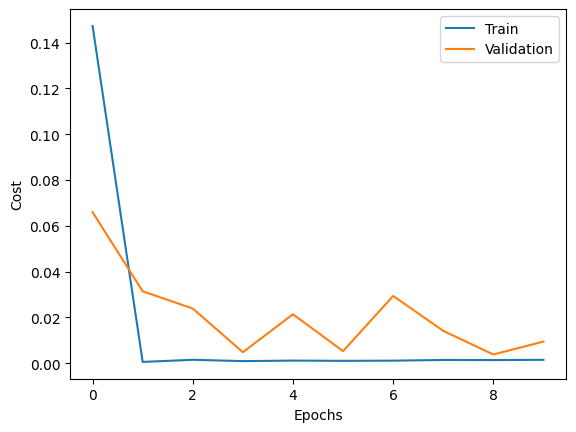

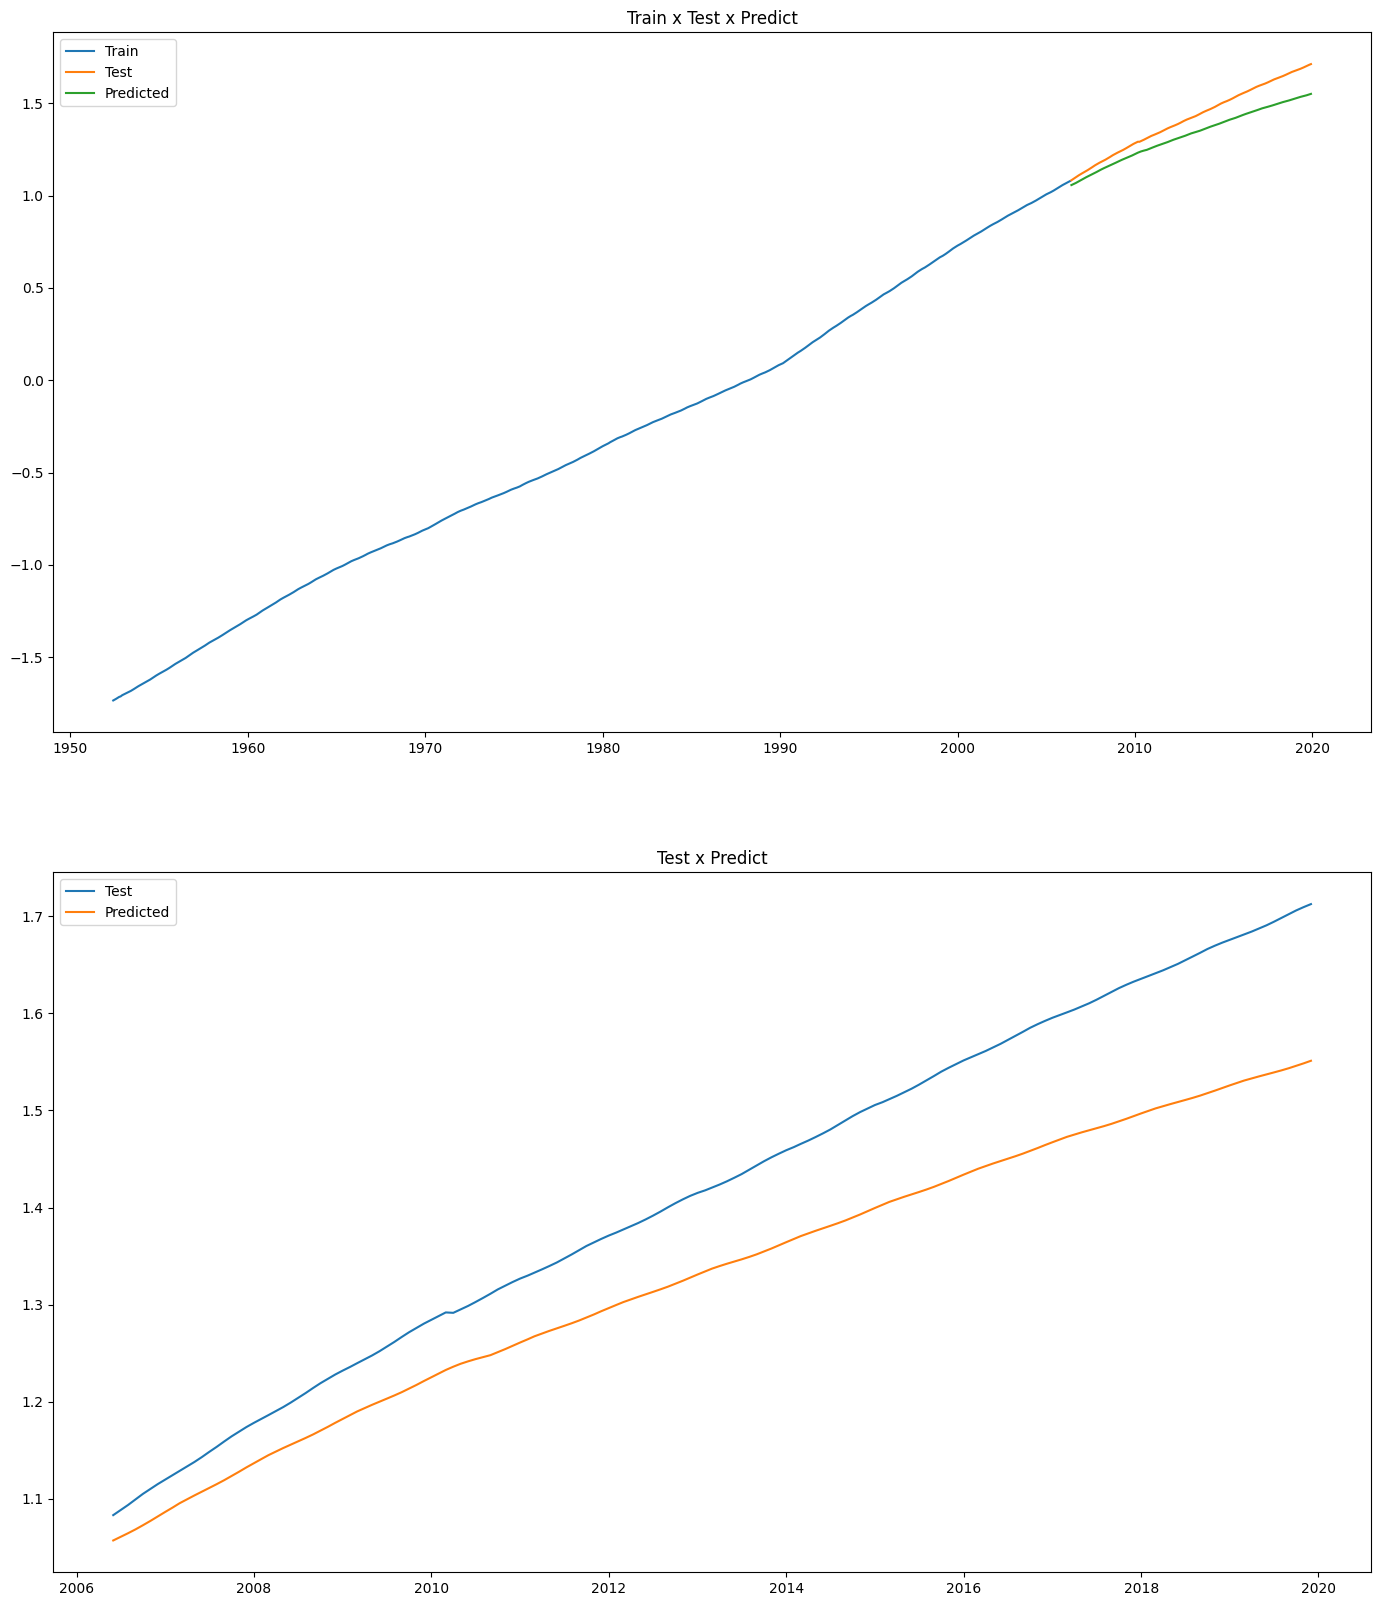

In [59]:
result = model7.fit(x_train,y_train,validation_data=(x_test,y_test),
                   epochs=10)
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(['Train','Validation'])
plt.xlabel('Epochs')
plt.ylabel('Cost')

y_predicted = model7.predict(x_test)
results_chart(y_predicted, y_test, y_train, df['date'].to_numpy(), window)